# MAFS6010Z Project 1 Code Report
***



In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy import stats

In [2]:
application_train = pd.read_csv('application_train.csv')
application_test = pd.read_csv('application_test.csv')
previous_application = pd.read_csv('previous_application.csv')
installments_payments = pd.read_csv('installments_payments.csv')
HomeCredit_columns_description = pd.read_csv('HomeCredit_columns_description.csv', encoding='ISO-8859-1')
bureau_balance = pd.read_csv('bureau_balance.csv')
bureau = pd.read_csv('bureau.csv')

# 1 Data Cleaning

- Note: This section is dedicated to removing columns with missing values exceeding 60%, while the remaining missing values will be addressed in Chapter 3: "Feature Engineering"

## 1.1 Missing Value

Observe the characteristics of deleted variables
- OWN_CAR_AGE: Age of client's car.
- Other variables all come from one description: Normalized information about building where the client lives.

In [3]:
def remove_missingvalue_columns(train, test, threshold = 0):
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    if (missing_train_columns == missing_test_columns):
        print('The columns deleted from the test set and the training set are the same.')
    return train, test

In [38]:
train, test = remove_missingvalue_columns(application_train, application_test, 60)

There are 17 columns with greater than 60% missing values.
The columns deleted from the test set and the training set are the same.


## Type

- Convert text variables into categorical variables.
- Convert binary variables identified as numerical variables into categorical variables.

In [6]:
def column_type(df):
    category_list = train.select_dtypes(include=['object']).columns.tolist()
    for column in train.select_dtypes(include=['int64', 'float64']).columns:
        if train[column].nunique() == 2 and set(train[column]) == {0, 1}:
            category_list.append(train[column].name)
    for column in df.columns[df.columns.isin(category_list)]:
        df[column] = df[column].astype('category')

In [39]:
column_type(test); column_type(train)
test.info(); train.info()

# 2 Exploratory Data Analysis

## 2.1 Categorical Variable

### 2.1.1 Chi-square Test 

In accordance with the Chi-square Test, at a confidence level of 0.05, we found that all categorical variables are statistically significant.

In [120]:
p_list =[]
chi2_list = []
dummy_list = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'WEEKDAY_APPR_PROCESS_START',
              'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_TYPE_SUITE',
              'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
train.replace('XNA', np.nan, inplace=True)
for i in dummy_list:
    contingency_table = pd.crosstab(train['TARGET'], train[i])
    res = chi2_contingency(contingency_table)
    chi2_list.append(res.statistic); p_list.append(res.pvalue)
    
pd.options.display.float_format = '{:.8f}'.format
pd.DataFrame(data={'Statistic': chi2_list, 'p-value': p_list}, index=dummy_list)

,Statistic,p-value
NAME_CONTRACT_TYPE,293.15054220,0.00000000
CODE_GENDER,920.00572542,0.00000000
FLAG_OWN_CAR,146.65601826,0.00000000
FLAG_OWN_REALTY,11.57582730,0.00066815
WEEKDAY_APPR_PROCESS_START,15.38755691,0.01744737
NAME_INCOME_TYPE,1253.47080809,0.00000000
NAME_EDUCATION_TYPE,1019.21318731,0.00000000
NAME_FAMILY_STATUS,504.69408256,0.00000000
NAME_HOUSING_TYPE,420.55618984,0.00000000
NAME_TYPE_SUITE,32.82531466,0.00001133


### 2.1.2 Visualization

Based on the default rate of categorical variables, we can observe a significant relationship between the independent variables and the dependent variable (default). Apart from binary variables, factors such as income level, educational attainment, and employment type also exhibit clear associations with default.

In [254]:
def eda_visual(df, variable, ax1, rotation=False):
    count = df[variable].value_counts()
    rate = pd.crosstab(df[variable], df['TARGET'])
    rate = rate[1].div(rate.sum(axis=1)) * 100
    df1 = pd.DataFrame({'count': count, 'default rate': rate})
    
    ax1.bar(df1.index, df1['count'], width = 0.3, color = 'mediumpurple', alpha = 0.8, label='Count') # , color='b', alpha=0.7
    ax1.tick_params(axis='y', labelcolor='mediumpurple')
    if rotation:
        plt.xticks(rotation=90)
    ax1.spines[['left', 'right', 'top']].set_visible(False)
    ax1.grid(ls = "--", lw = .5)

    ax2 = ax1.twinx()
    ax2.plot(df1.index, df1['default rate'], marker='o', linewidth = 3, color = 'orange', alpha = 0.7, label='Default Rate')
    ax2.spines[['left', 'right', 'top']].set_visible(False)
    ax2.tick_params(axis='y', labelcolor='orange')
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    ax1.legend(lines, labels, loc='upper left')
    
    plt.rc('font', family='Times New Roman')
    plt.title(variable) 
    plt.tight_layout()

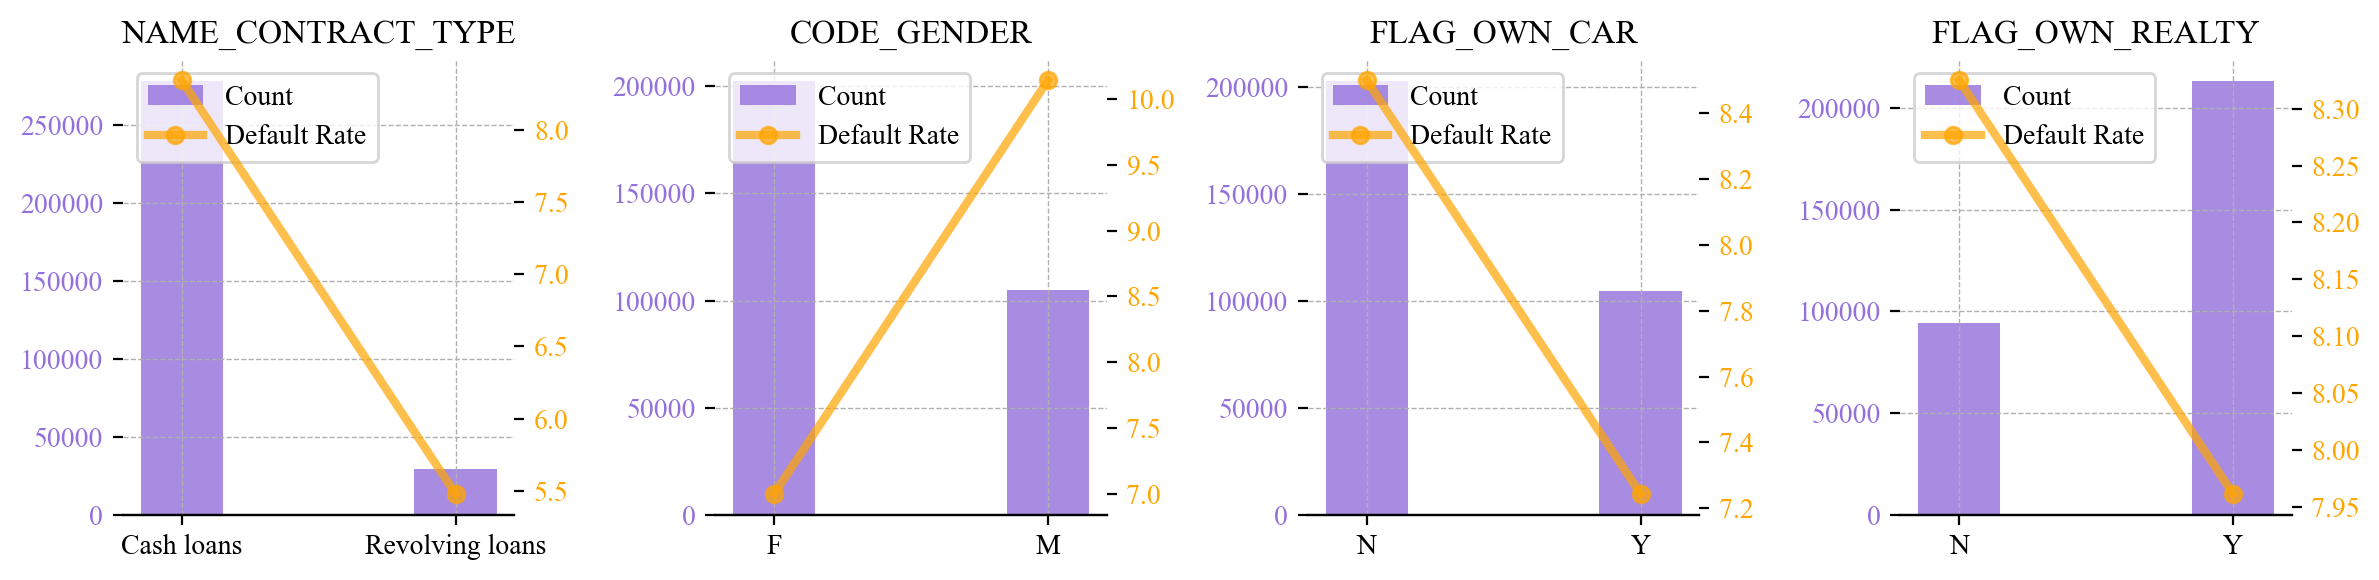

In [255]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3), dpi=200)
eda_visual(train, 'NAME_CONTRACT_TYPE', ax1)
eda_visual(train, 'CODE_GENDER', ax2)
eda_visual(train, 'FLAG_OWN_CAR', ax3)
eda_visual(train, 'FLAG_OWN_REALTY', ax4)

plt.show()

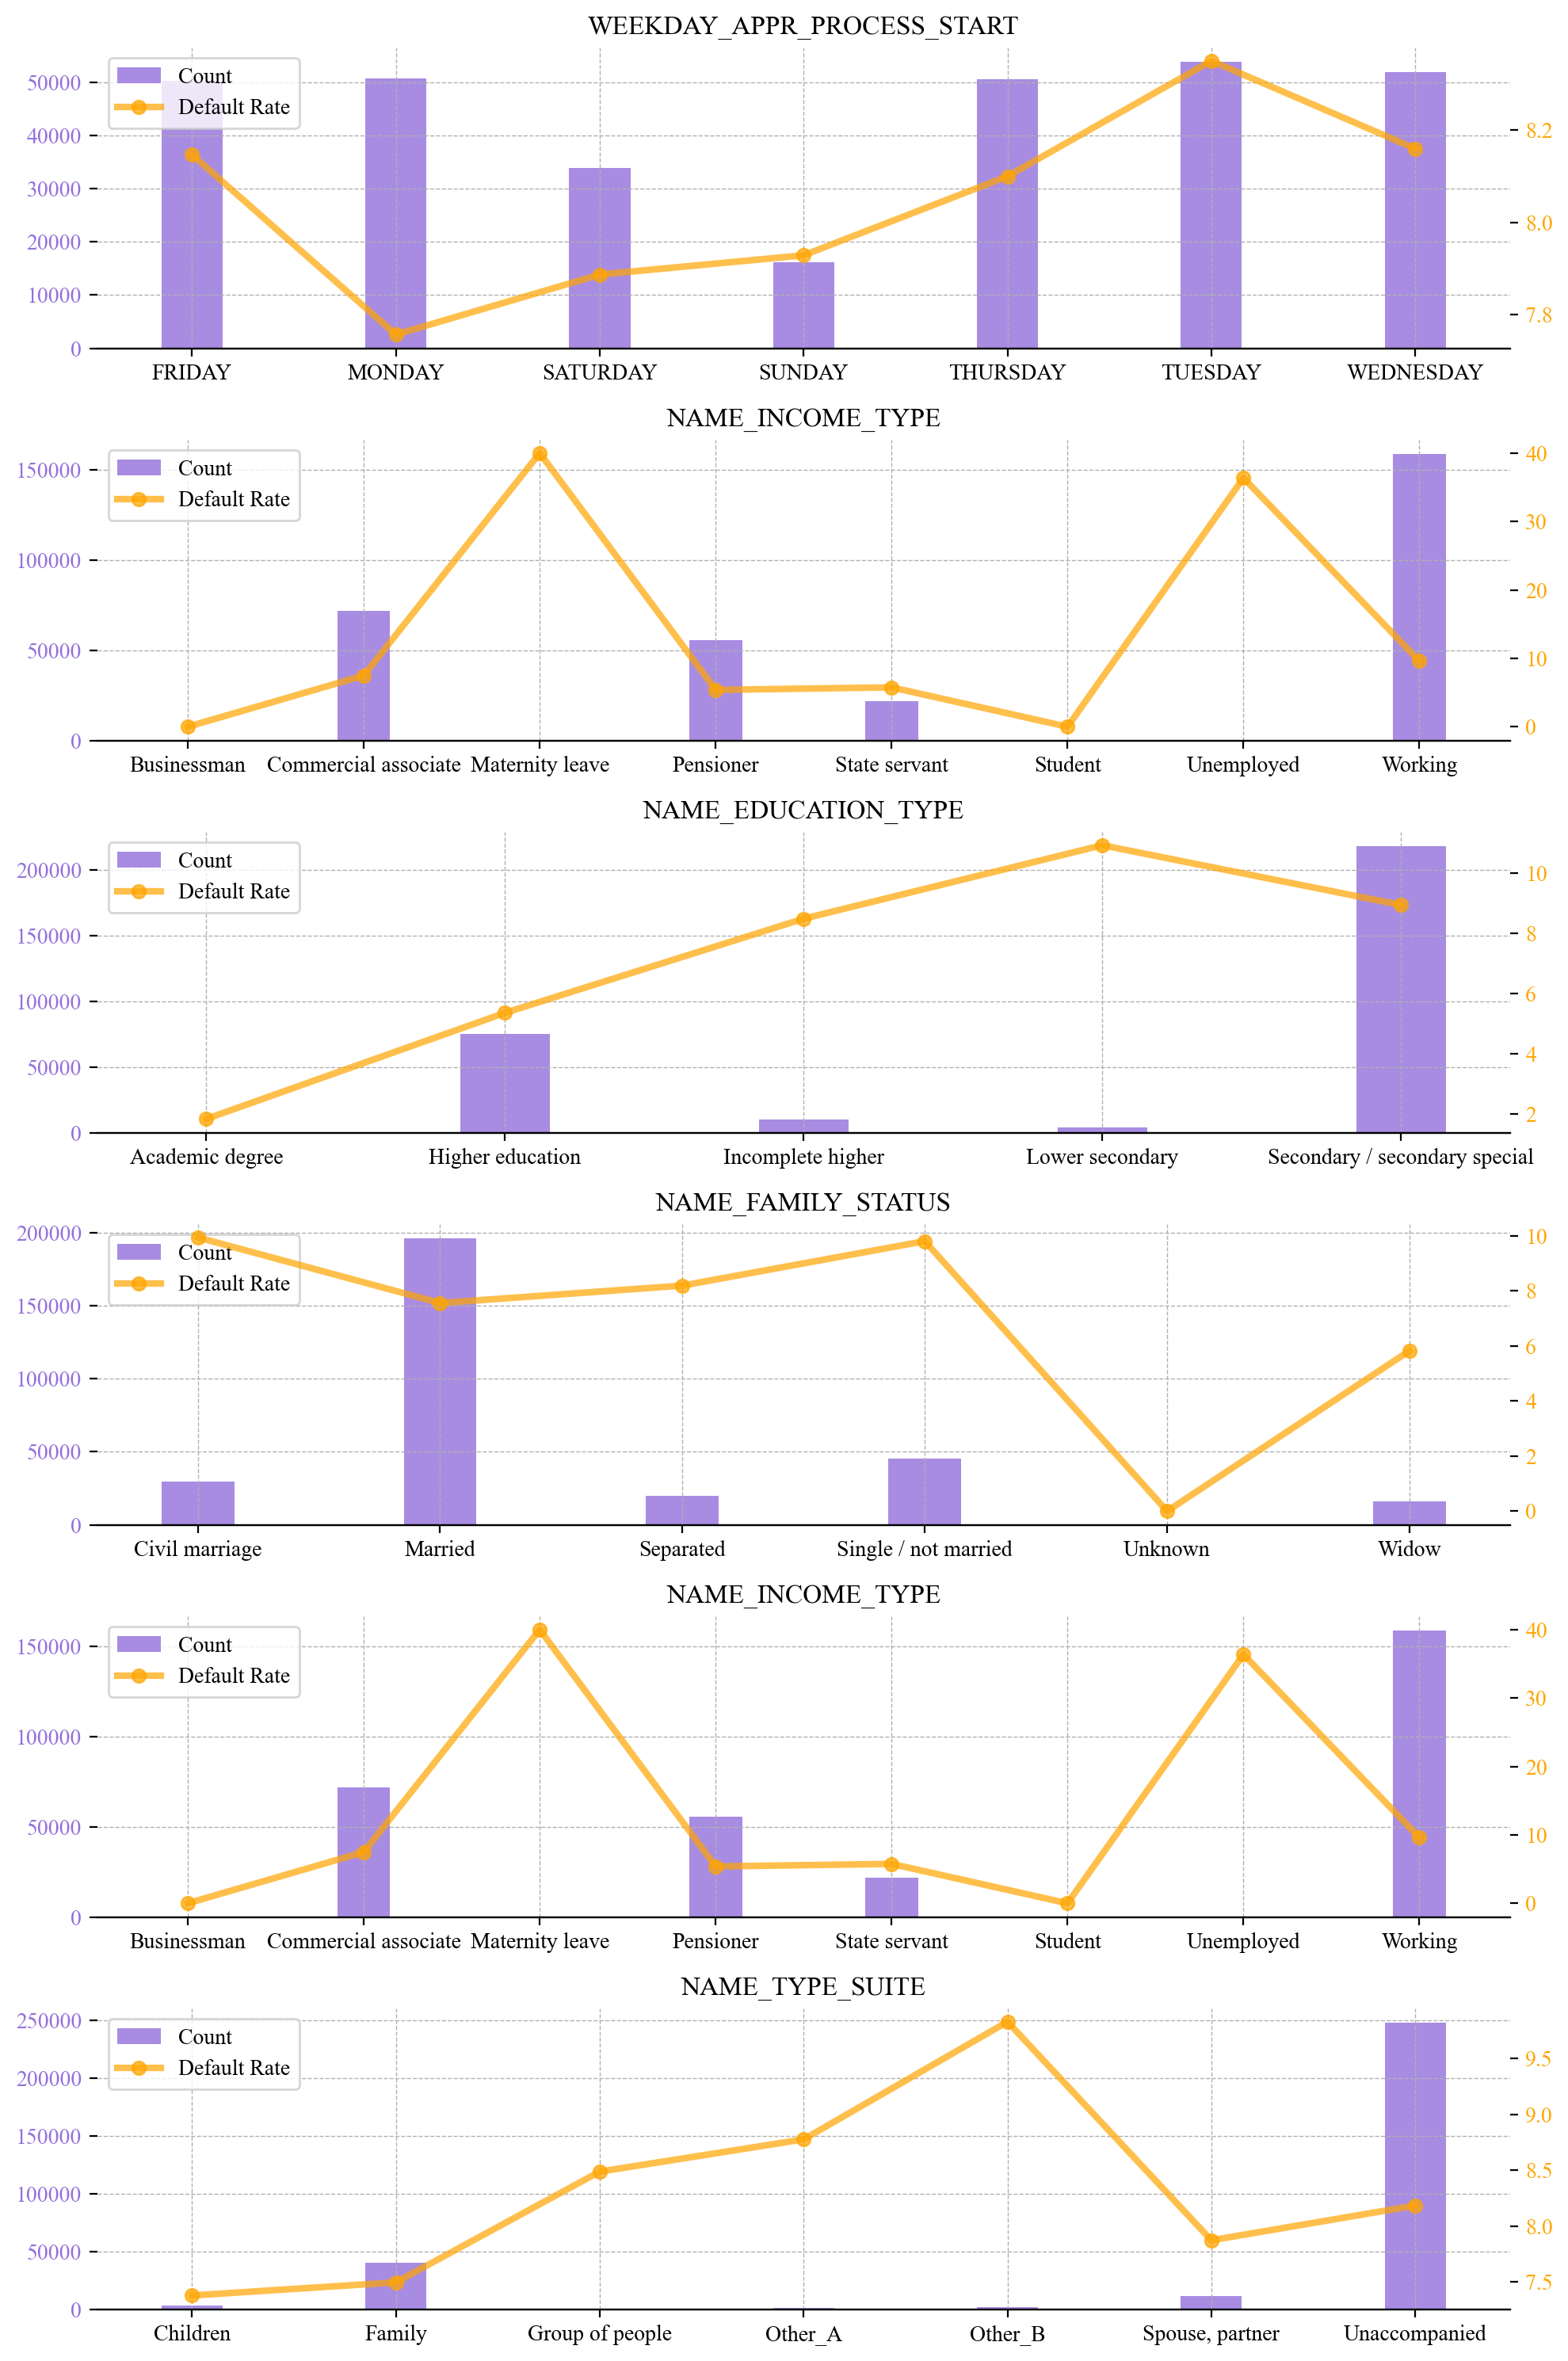

In [256]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(10, 15), dpi=200)
eda_visual(train, 'WEEKDAY_APPR_PROCESS_START', ax1)
eda_visual(train, 'NAME_INCOME_TYPE', ax2)
eda_visual(train, 'NAME_EDUCATION_TYPE', ax3)
eda_visual(train, 'NAME_FAMILY_STATUS', ax4)
eda_visual(train, 'NAME_INCOME_TYPE', ax5)
eda_visual(train, 'NAME_TYPE_SUITE', ax6)
plt.show()

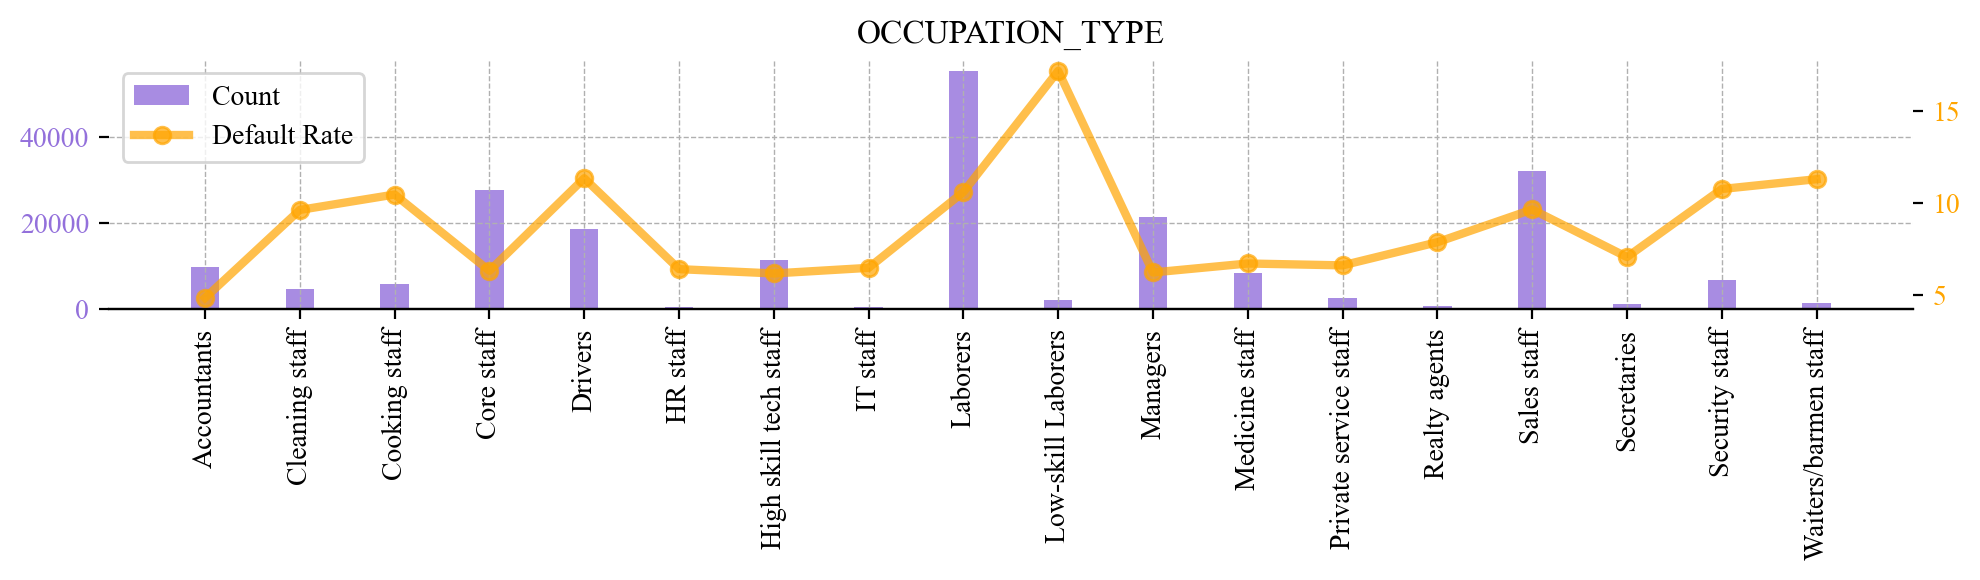

In [257]:
fig, ax1 = plt.subplots(figsize=(10, 3), dpi=200)
eda_visual(train, 'OCCUPATION_TYPE', ax1, rotation=True)
plt.show()

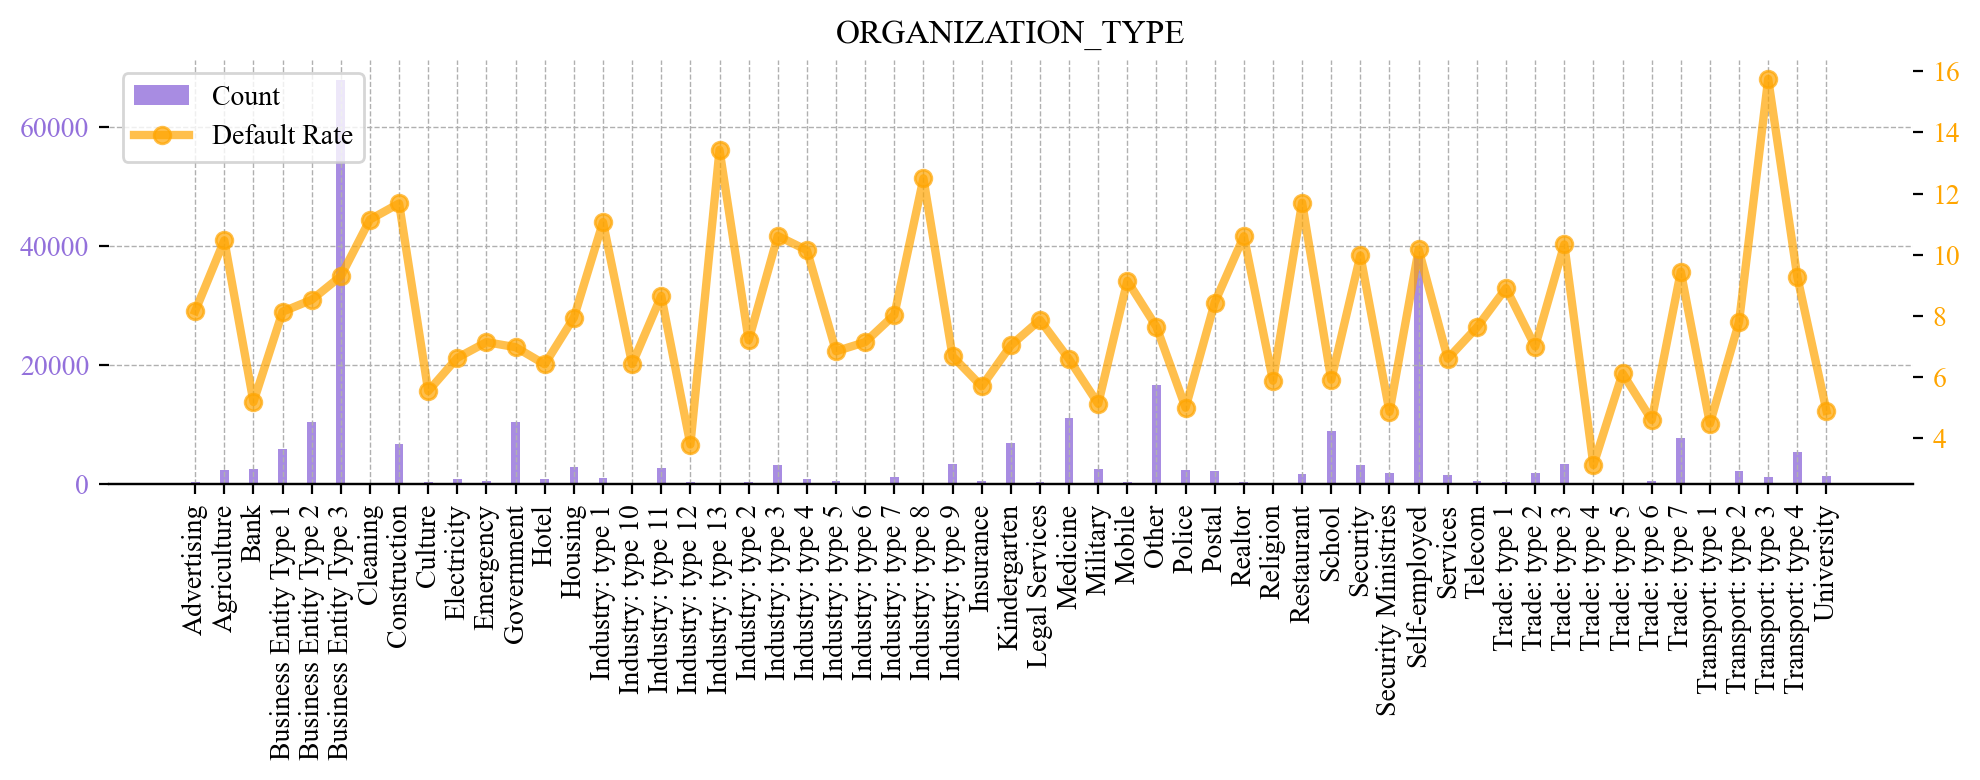

In [258]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=200)
eda_visual(train, 'ORGANIZATION_TYPE', ax1, rotation=True)
plt.show()

## 2.2 Numerical Variable

### 2.2.1 Point-Biserial Correlation

In the case of numeric independent variables, we utilized the Point-Biserial Correlation to examine their relationship with the dependent variable. It can be observed that only a small portion of the independent variables exhibited significance levels greater than 0.05.

In [312]:
train_num = train.select_dtypes(include=['int64', 'float64']).columns
BUILDING_list = HomeCredit_columns_description[HomeCredit_columns_description['Description'].str.contains('building where the client lives')]['Row'].tolist()
BUILDING_list = set(BUILDING_list).intersection(set(train_num))
num_list = list(BUILDING_list.symmetric_difference(set(train_num)))

In [313]:
df1 = train[['TARGET'] + num_list]
df1.fillna(0, inplace=True)
p_list =[]
stat_list = []

for i in num_list:
    res = stats.pointbiserialr(df1['TARGET'], df1[i])
    stat_list.append(res.statistic); p_list.append(res.pvalue)
    
pd.options.display.float_format = '{:.8f}'.format
pd.DataFrame(data={'Statistic': stat_list, 'p-value': p_list}, index=num_list)

,Statistic,p-value
AMT_REQ_CREDIT_BUREAU_YEAR,0.00552170,0.00219864
EXT_SOURCE_2,-0.15902968,0.00000000
REGION_RATING_CLIENT,0.05889901,0.00000000
AMT_REQ_CREDIT_BUREAU_QRT,-0.00583314,0.00121769
AMT_REQ_CREDIT_BUREAU_DAY,0.00170107,0.34552500
REGION_RATING_CLIENT_W_CITY,0.06089267,0.00000000
CNT_CHILDREN,0.01918713,0.00000000
DEF_60_CNT_SOCIAL_CIRCLE,0.03140053,0.00000000
DAYS_BIRTH,0.07823931,0.00000000
EXT_SOURCE_1,-0.06469813,0.00000000


### 2.2.2 Visualization

In the visualization section, due to the abundance of numerical independent variables, we opted for the significant "DAYS_BIRTH" variable. We displayed the variable's density and grouped default probabilities. It is evident that default probabilities decrease with increasing age. We believe this variable will play a role in subsequent models.

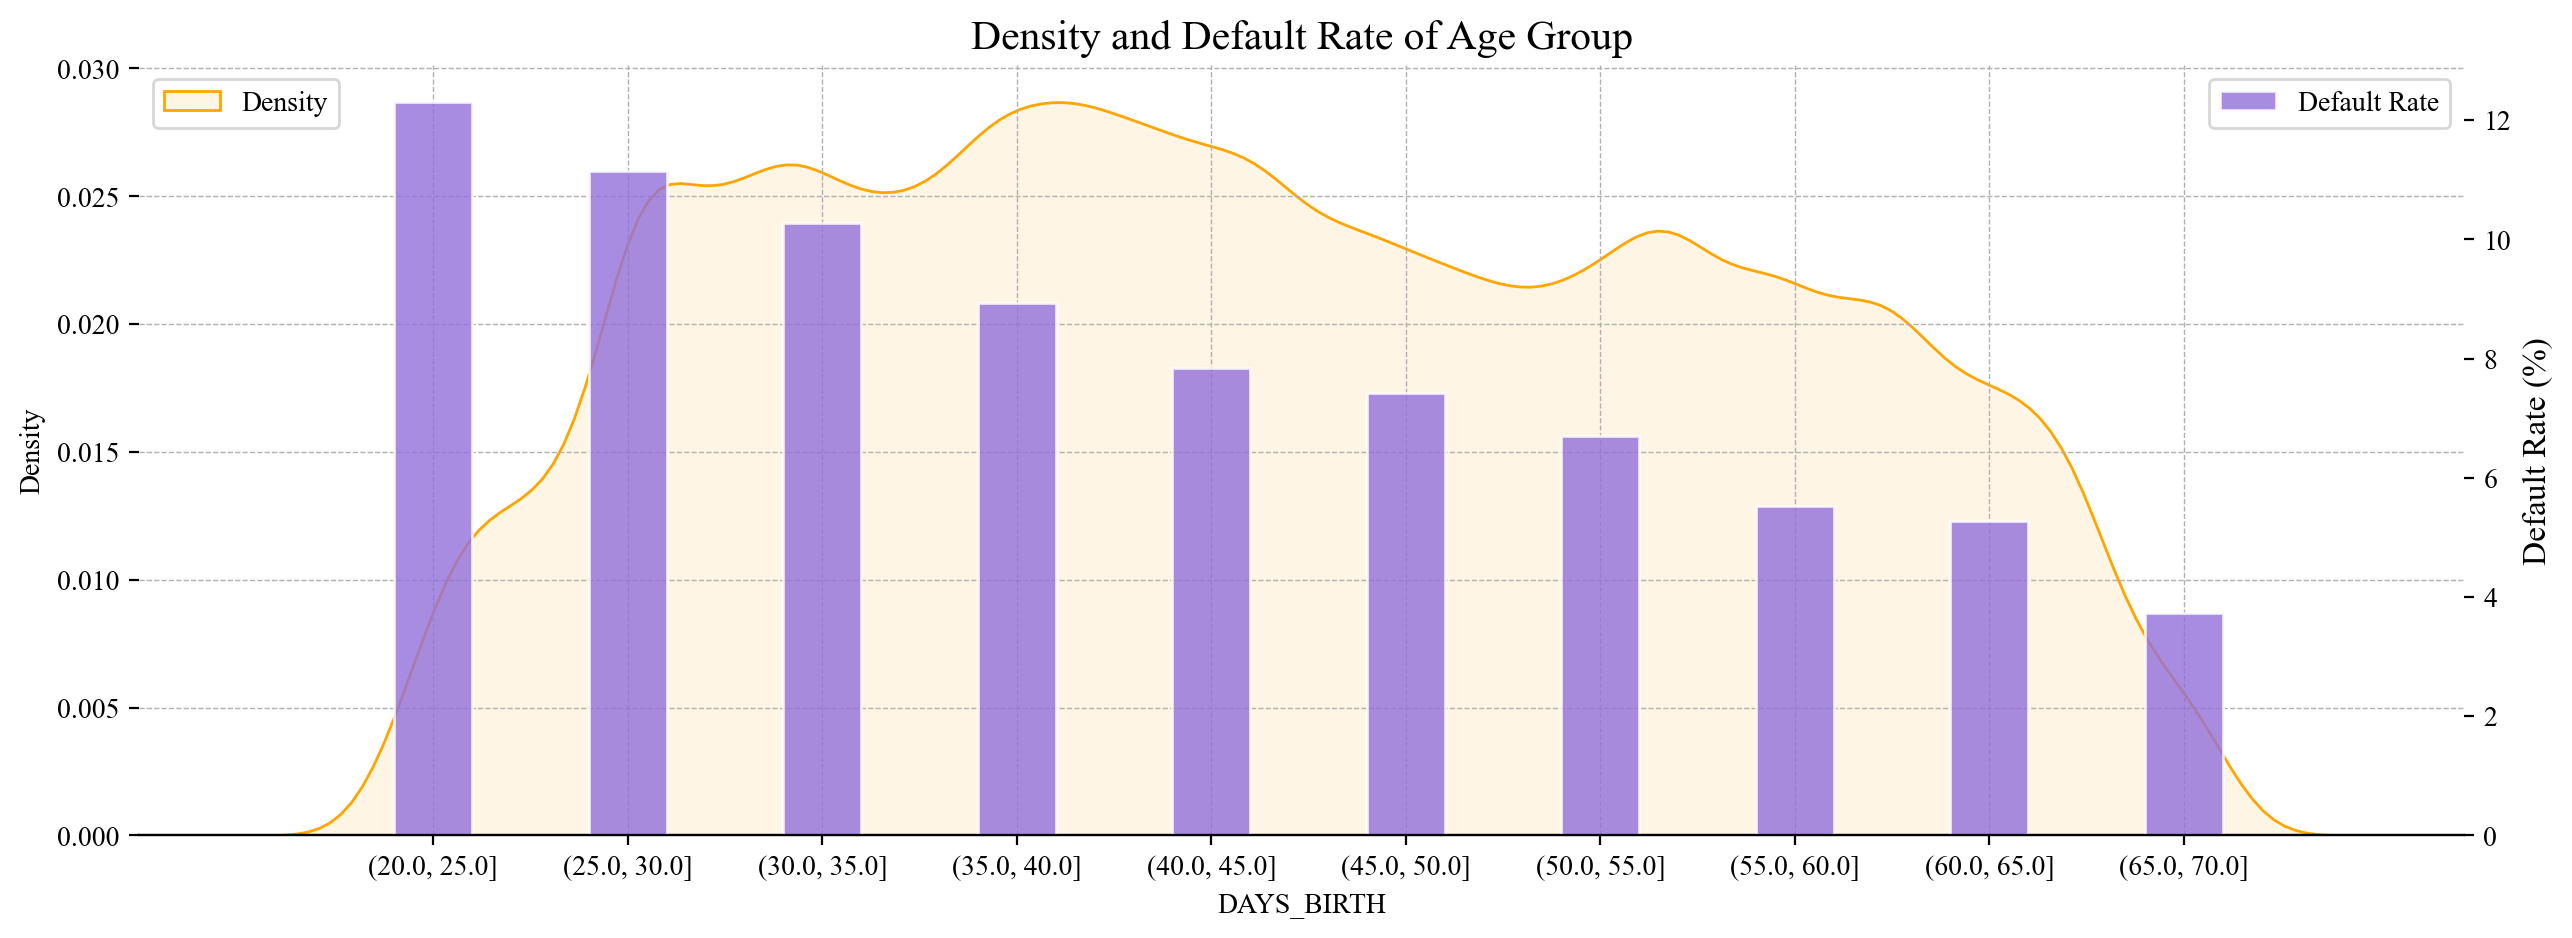

In [121]:
age = train[['DAYS_BIRTH', 'TARGET']]
age = age.copy()
age['YEARS_BIRTH'] = age['DAYS_BIRTH'] / -365
age['YEARS_BINNED'] = pd.cut(age['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age['TARGET'] = age['TARGET'].astype('int64')
age_groups = age.groupby('YEARS_BINNED').mean()

fig, ax1 = plt.subplots(figsize=(15, 5), dpi=200)
    
ax1.spines[['left', 'right', 'top']].set_visible(False)
ax1.grid(ls = "--", lw = .5)
sns.kdeplot(-train['DAYS_BIRTH']/365, fill=True, color='orange', alpha=0.1, label='Density')

x_labels = age_groups.index.astype(str)
x_range = np.arange(22.5, 22.5 + 5 * 10, 5)
ax2 = ax1.twinx()
ax2.spines[['left', 'right', 'top']].set_visible(False)
ax2.bar(x_range, 100 * age_groups['TARGET'], color = 'mediumpurple', width = 2, alpha = 0.8, edgecolor='w', label='Default Rate')
ax2.set_xticks(x_range)
ax2.set_xticklabels(x_labels)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Density and Default Rate of Age Group',fontsize = 15)
plt.xlabel('Age Group (Years)',fontsize = 12)
plt.ylabel('Default Rate (%)',fontsize = 12)
plt.xticks(rotation = 75)
plt.rc('font', family='Times New Roman')
plt.show()

# 3 Feature Engineering

## 3.1 Train/Test

In the case of the training and test datasets, we selected most of the variables and performed some feature transformations. 

For example, we converted "DAYS_BIRTH" into age, took the average of the three "EXT_SOURCE" variables to mitigate multicollinearity, and ultimately replaced missing values for both categorical and numerical variables.

In [125]:
def variable_clean(df, train):    
    DOCUMENT_list = [col for col in df.columns if 'FLAG_DOCUMENT_' in col]
    df['FLAG_DOCUMENT'] = df[DOCUMENT_list].astype(int).sum(axis=1)
    
    DAYS_list = [col for col in df if 'DAYS_' in col]
    YEARS_list = [item.replace('DAYS_', 'YEARS_') if 'DAYS_' in item else item for item in DAYS_list]
    df[YEARS_list] = -df[DAYS_list]/365
    
    NOT_WORK_LIVE_list = [col for col in df.columns if ('_NOT_WORK' in col or '_NOT_LIVE' in col)]
    df['NOT_WORK_LIVE'] = df[NOT_WORK_LIVE_list].astype('int64').apply(lambda row: 1 if row.any() else 0, axis=1).astype('category')
    
    EXT_SOURCE_list = [col for col in df.columns if 'EXT_SOURCE_' in col]
    df['EXT_SOURCE'] = df[EXT_SOURCE_list].mean(axis=1)
    
    BUILDING_list = HomeCredit_columns_description[HomeCredit_columns_description['Description'].str.contains('building where the client lives')]['Row'].tolist()
    BUILDING_list = list(set(BUILDING_list).intersection(set(df.columns)))
    
    columns_to_drop = DOCUMENT_list + DAYS_list + ['REGION_RATING_CLIENT'] + NOT_WORK_LIVE_list + EXT_SOURCE_list + BUILDING_list
    df = df.drop(columns=columns_to_drop)
    
    df.replace('XNA', np.nan, inplace=True)
    for column in df.select_dtypes(include=['int64', 'float64']).columns:
        df[column].fillna(0, inplace=True)
    
    df_copy = df.copy()
    for column in df_copy.select_dtypes(include=['category']).columns:
        mode_value = train[column].mode()[0]
        df_copy[column].fillna(mode_value, inplace=True) 
        
    dummy_list = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'WEEKDAY_APPR_PROCESS_START',
                  'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_TYPE_SUITE',
                  'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
    df_copy = pd.concat([df_copy, pd.get_dummies(df_copy[dummy_list], prefix=dummy_list, drop_first=True)], axis=1) 
    df_copy = df_copy.drop(columns=dummy_list)
    
    return df_copy

df_train = variable_clean(train, train)
df_test = variable_clean(test, train)

train_labels = df_train['TARGET']
df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)
df_train['TARGET'] = train_labels

## 3.2 User Identify - Perious Default

Inspired by the second-place finisher in the Kaggle competition, we attempted to identify the same users for the unique variable "SK_ID_CURR." Using the "previous application" table, we found that it was possible to match different "SK_ID_CURR" values based on the time intervals between "DAYS_BIRTH" and "DAYS_DECISION" in the previous application. This allowed us to determine which "SK_ID_CURR" values corresponded to the same individual. 

We then created a new variable called "previous default" to ascertain whether the user associated with this "SK_ID_CURR" had a previous default record.

In [131]:
prev_app = previous_application[['SK_ID_CURR', 'DAYS_DECISION']].drop_duplicates()
app_train = application_train[['SK_ID_CURR', 'DAYS_BIRTH', 'CODE_GENDER']]
app_test = application_test[['SK_ID_CURR', 'DAYS_BIRTH', 'CODE_GENDER']]
prev_app = pd.merge(prev_app, pd.concat([app_train, app_test], axis=0), how='left', on='SK_ID_CURR')
prev_app['DAYS_BIRTH_PREV'] = prev_app['DAYS_BIRTH'] - prev_app['DAYS_DECISION']
prev_app = prev_app.sort_values(by=['SK_ID_CURR', 'DAYS_DECISION']).reset_index()
prev_app_grouped = prev_app.groupby('SK_ID_CURR')['DAYS_DECISION'].diff().reset_index(name='DAYS_DECISION_DIFF')
prev_app = prev_app.merge(prev_app_grouped, left_index=True, right_index=True, how='left')
prev_app['DAYS_DECISION_DIFF'] = -prev_app['DAYS_DECISION_DIFF']
prev_app = prev_app[['SK_ID_CURR', 'CODE_GENDER', 'DAYS_DECISION', 'DAYS_BIRTH', 'DAYS_DECISION_DIFF', 'DAYS_BIRTH_PREV']]

prev_app_1 = prev_app[['SK_ID_CURR', 'CODE_GENDER', 'DAYS_DECISION', 'DAYS_BIRTH']]
prev_app_2 = prev_app[['SK_ID_CURR', 'CODE_GENDER', 'DAYS_DECISION_DIFF', 'DAYS_BIRTH_PREV']]
prev_app_2.columns = prev_app_1.columns
merged = prev_app_1.merge(prev_app_2, on=['CODE_GENDER', 'DAYS_DECISION', 'DAYS_BIRTH'], how='inner')

pairs = merged[['SK_ID_CURR_x', 'SK_ID_CURR_y']]
pairs = pairs.copy()
pairs['x_target'] = pairs['SK_ID_CURR_x'].map(train.set_index('SK_ID_CURR')['TARGET'])
pairs['y_target'] = pairs['SK_ID_CURR_y'].map(train.set_index('SK_ID_CURR')['TARGET'])

df_birth = pd.concat([app_train, app_test], axis=0)
pairs['x_birth'] = pairs['SK_ID_CURR_x'].map(df_birth.set_index('SK_ID_CURR')['DAYS_BIRTH'])
pairs['y_birth'] = pairs['SK_ID_CURR_y'].map(df_birth.set_index('SK_ID_CURR')['DAYS_BIRTH'])

combined_series = pd.concat([pairs['SK_ID_CURR_x'], pairs['SK_ID_CURR_y']], ignore_index=True)
combined_unique = combined_series.drop_duplicates().reset_index()

birth_data = df_birth[df_birth['SK_ID_CURR'].isin(combined_unique[0].tolist())][['SK_ID_CURR', 'DAYS_BIRTH']]
result_df = pd.DataFrame({'SK_ID_CURR': combined_unique[0].tolist(), 'prev_default': np.nan})

for i, row in birth_data.iterrows():
    curr_SK_ID_CURR = row['SK_ID_CURR']
    birth = row['DAYS_BIRTH']
    
    df = pairs[(pairs['SK_ID_CURR_x'] == curr_SK_ID_CURR) | (pairs['SK_ID_CURR_y'] == curr_SK_ID_CURR)]
    df2 = df[(df['x_birth'] < birth) | (df['y_birth'] < birth)]
    
    x_condition = df2['x_birth'] == birth
    y_condition = df2['y_birth'] == birth
    
    df2 = df2.copy()
    df2['prev_default'] = np.where(x_condition, df2['y_target'], np.where(y_condition, df2['x_target'], None))
    prev_default = df2['prev_default'].sum()
    
    result_df.loc[result_df['SK_ID_CURR'] == curr_SK_ID_CURR, 'prev_default'] = prev_default

df_train = df_train.merge(result_df, how = 'left', on = 'SK_ID_CURR')
df_test = df_test.merge(result_df, how = 'left', on = 'SK_ID_CURR')
df_train.fillna(0, inplace=True); df_test.fillna(0, inplace=True)

## 3.3 installments_payments

Includes original features and new features constructed by simple operations, such as calculate the total default amount for each SK_ID_CIRR to conduct a new feature.

In [16]:
installments_payments['DEFAULT_DAY']=installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
tem =installments_payments[installments_payments['DEFAULT_DAY'] > 0]
tem = tem.loc[: ,['SK_ID_CURR','DEFAULT_DAY']]
default_days_agg = tem.groupby('SK_ID_CURR', as_index = False).agg({ 'DEFAULT_DAY' : ['sum', 'count']})
default_days_agg.columns = ['SK_ID_CURR', 'DEFAULT_DAY_SUM', 'DEFAULT_DAY_COUNT']

installments_payments['DEFAULT_AMT']=installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']
tem =installments_payments[installments_payments['DEFAULT_AMT'] > 0]
tem = tem.loc[: ,['SK_ID_CURR','DEFAULT_AMT']]
default_AMT_agg = tem.groupby('SK_ID_CURR', as_index = False).agg({ 'DEFAULT_AMT' : ['sum', 'count']})
default_AMT_agg.columns = ['SK_ID_CURR', 'DEFAULT_AMT_SUM', 'DEFAULT_AMT_COUNT']

df_train = df_train.merge(default_days_agg, how = 'left', on = 'SK_ID_CURR')
df_test = df_test.merge(default_days_agg, how = 'left', on = 'SK_ID_CURR')

df_train = df_train.merge(default_AMT_agg, how = 'left', on = 'SK_ID_CURR')
df_test = df_test.merge(default_AMT_agg, how = 'left', on = 'SK_ID_CURR')

## 3.4 previous_application

Define functions that do one-hot encoding on a dataframe, then conduct some new features by performing a calculation on the grouped data ,and match the aggregated statistics to the appropriate client.

In [126]:
def one_hot_encoder(df, nan_category = True):
    original_cols = list(df.columns)
    categorial_cols = [col for col in df.columns if df[col].dtypes == 'object']
    df = pd.get_dummies(df, columns = categorial_cols, dummy_na = nan_category, drop_first=True)
    new_columns = [i for i in df.columns if i not in original_cols]
    return df, new_columns

previous_app = previous_application
previous_app_numeric = previous_app.select_dtypes(include=['number'])
missings = previous_app_numeric.loc[:,previous_app_numeric.isna().mean() >= 0.6]
highly_missing_features = missings.columns
previous_app.drop(highly_missing_features, axis=1, inplace=True)

previous_app_obj = previous_app.dtypes[previous_app.dtypes == 'object'].index
previous_app[previous_app_obj].apply(pd.Series.nunique, axis = 0)
previous_app, previous_app_cat = one_hot_encoder(previous_app)

NA_list = [col for col in previous_app.columns if 'XNA' in col or 'nan' in col or 'XAP' in col]
previous_app_cat = list(set(NA_list).symmetric_difference(set(previous_app_cat)))
previous_app = previous_app.drop(columns=NA_list)

cat_agg = { }
for i in previous_app_cat:
    cat_agg[i] = 'sum'
    
num_agg = {
    'AMT_ANNUITY': ['min','max','mean'],
    'AMT_APPLICATION':['min','max','mean'],
    'AMT_CREDIT':['min','max','mean'],
    'AMT_DOWN_PAYMENT':['min','max','mean'],
    'AMT_GOODS_PRICE':['min','max','mean'],
    'HOUR_APPR_PROCESS_START':['min','max','mean'],
    'RATE_DOWN_PAYMENT':['min','max','mean'],
    'DAYS_DECISION':['min','max','mean'],
    'CNT_PAYMENT':['sum','mean']
}

previous_application_agg = previous_app.groupby('SK_ID_CURR', as_index = False).agg({**cat_agg, **num_agg})
previous_application_agg.columns = ['_'.join(col) for col in previous_application_agg.columns.values]
previous_application_agg.columns = [col.upper() for col in previous_application_agg.columns.values]
previous_application_agg.rename(columns={'SK_ID_CURR_': 'SK_ID_CURR'}, inplace=True)

df_train = df_train.merge(previous_application_agg, how = 'left', on = 'SK_ID_CURR')
df_test = df_test.merge(previous_application_agg, how = 'left', on = 'SK_ID_CURR')
df_train.fillna(0, inplace=True); df_test.fillna(0, inplace=True)

## 3.5 bureau & bureau_balance

Bureau analysis: The significance of  ‘bureau’ and ‘bureau_balance’ datasets is weak, but we extracted some significant features via some statistical analysis, like calculating the minimum, maximum, summation, and so on.

In [22]:
b_obj = bureau.dtypes[bureau.dtypes == 'object'].index
bb_obj = bureau_balance.dtypes[bureau_balance.dtypes == 'object'].index
bureau[b_obj].apply(pd.Series.nunique, axis = 0)
bureau_balance[bb_obj].apply(pd.Series.nunique, axis = 0)

b, b_cat = one_hot_encoder(bureau)
bb, bb_cat = one_hot_encoder(bureau_balance)

NA_list = [col for col in b.columns if 'nan' in col]
b_cat = list(set(NA_list).symmetric_difference(set(b_cat)))
b = b.drop(columns=NA_list)

NA_list = [col for col in bb.columns if 'nan' in col]
bb_cat = list(set(NA_list).symmetric_difference(set(bb_cat)))
bb = bb.drop(columns=NA_list)

b = b.merge(bb, how= 'left', on='SK_ID_BUREAU')
b.drop(['SK_ID_BUREAU'], axis= 1, inplace= True)

tem = b.columns.tolist()
num_agg = { }
for i in tem:
    if i != 'SK_ID_CURR':
        num_agg[i] = ['min', 'max', 'mean', 'var', 'sum']
        
bureau_agg = b.groupby('SK_ID_CURR', as_index = False).agg(num_agg)

tem = [ ]
tem.append('SK_ID_CURR')
for i in bureau_agg.columns.tolist():
    if i[0] != 'SK_ID_CURR':
        tem.append('bureau' + '_' + str(i[0]) + '_' + str(i[1]))

bureau_agg.columns = pd.Index(tem)
df_train = df_train.merge(bureau_agg, how = 'left', on = 'SK_ID_CURR')
df_test = df_test.merge(bureau_agg, how = 'left', on = 'SK_ID_CURR')
df_train.fillna(0, inplace=True); df_test.fillna(0, inplace=True)

# 4 Model Construction
***

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import lightgbm as lgb

import pandas as pd
import numpy as np
import gc
import os

In [1]:
def model_construct(train_data, test_data, model, n_folds = 5):
    """

    :param model:
    :param train_data:
    :param test_data:
    :param n_folds: number of folds to use for cross validation, default 5
    :return:
    """
    # Get Data
    train_ids = train_data['SK_ID_CURR']
    test_ids = test_data['SK_ID_CURR']

    x_train = train_data.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    x_test = test_data.drop('SK_ID_CURR', axis=1)
    y_train = train_data['TARGET']

   # Extract feature names
    feature_names = list(x_train.columns)

    # Convert to np arrays
    x_train = np.array(x_train)
    x_test = np.array(x_test)

    # Preprocessing
    imputer = SimpleImputer(strategy='most_frequent')
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Imputer
    x_train = imputer.fit_transform(x_train)
    x_test = imputer.transform(x_test)
    # Scalar
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    print('Training Data Shape: ', x_train.shape)
    print('Testing Data Shape: ', x_test.shape)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 9170)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
    test_predictions = np.zeros(x_test.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(x_train.shape[0])

    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []


    if model == 'logistic':
        # K fold iteration
        for train_index, valid_index in k_fold.split(x_train):
            # train set
            x_tr, y_tr = x_train[train_index], y_train[train_index]
            # valid set
            x_va, y_va = x_train[valid_index], y_train[valid_index]

            lr_model =  LogisticRegression(C = 0.0001, random_state=9171)
            lr_model.fit(x_tr, y_tr)

            # feature importance
            feature_importance_values += np.abs(lr_model.coef_[0]) / k_fold.n_splits
            # test prediction
            test_predictions += lr_model.predict_proba(x_test)[:, 1] / k_fold.n_splits  # only need the second column
            # valid predition
            out_of_fold[valid_index] = lr_model.predict_proba(x_va)[:, 1]

            # train score/ valid score
            train_scores.append(roc_auc_score(y_tr, lr_model.predict_proba(x_tr)[:, 1]))
            valid_scores.append(roc_auc_score(y_va, lr_model.predict_proba(x_va)[:, 1]))

            gc.enable()
            del lr_model, x_tr, x_va, y_tr, y_va
            gc.collect()

    elif model == 'RandomForest':
        # K fold iteration
        for train_index, valid_index in k_fold.split(x_train):
            # train set
            x_tr, y_tr = x_train[train_index], y_train[train_index]
            # valid set
            x_va, y_va = x_train[valid_index], y_train[valid_index]

            # model
            rf_model = RandomForestClassifier(n_estimators = 100, random_state = 9172, verbose = 1, n_jobs = -1)
            rf_model.fit(x_tr, y_tr)

            # feature importance
            feature_importance_values += rf_model.feature_importances_ / k_fold.n_splits
            # test prediction
            test_predictions += rf_model.predict_proba(x_test)[:, 1] / k_fold.n_splits
            # valid prediction
            out_of_fold[valid_index] = rf_model.predict_proba(x_va)[:, 1]

            # train / valid score
            train_scores.append(roc_auc_score(y_tr, rf_model.predict_proba(x_tr)[:, 1]))
            valid_scores.append(roc_auc_score(y_va, rf_model.predict_proba(x_va)[:, 1]))

            gc.enable()
            del rf_model, x_tr, x_va, y_tr, y_va
            gc.collect()

    elif model == 'lgbm':
        # K fold iteration
        for train_index, valid_index in k_fold.split(x_train):
            # train set
            x_tr, y_tr = x_train[train_index], y_train[train_index]
            # valid set
            x_va, y_va = x_train[valid_index], y_train[valid_index]

            # model
            lgb_model = lgb.LGBMClassifier(n_estimators=1000,
                                           objective = 'binary',
                                           learning_rate = 0.05,
                                           reg_alpha = 0.3,
                                           reg_lambda = 0.5,
                                           n_jobs = -1,
                                           random_state = 9173)
            lgb_model.fit(x_tr, y_tr,
                          eval_metric = 'auc',
                          eval_set= [(x_va, y_va), (x_tr, y_tr)],
                          eval_names=['valid', 'train'],
                          # early_stopping_rounds = 100,
                          callbacks=[lgb.log_evaluation(period=200), lgb.early_stopping(stopping_rounds=100)]
                          )
            best_iteration = lgb_model.best_iteration_

            # feature importances
            feature_importance_values += lgb_model.feature_importances_ / k_fold.n_splits
            # test prediction
            test_predictions += lgb_model.predict_proba(x_test, num_iteration=best_iteration)[:, 1] / k_fold.n_splits
            # valid prediction
            out_of_fold[valid_index] = lgb_model.predict_proba(x_va, num_iteration=best_iteration)[:, 1]

            # train / valid scores
            train_scores.append(lgb_model.best_score_['train']['auc'])
            valid_scores.append(lgb_model.best_score_['valid']['auc'])

            gc.enable()
            del lgb_model, x_tr, x_va, y_tr, y_va
            gc.collect()

    else:
        raise ValueError('Only support logistic, randomforest, lgbm model')


    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    valid_auc = roc_auc_score(y_train, out_of_fold)
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})

    return submission, feature_importance, metrics, out_of_fold


## 4.1 Model Performance
### Using Application tabel data only

In [ ]:
performance = {}
train = pd.read_csv('app_train.csv')
test = pd.read_csv('app_test.csv')

for model_n in ['logistic', 'RandomForest', 'lgbm']:
    submission, feature_importance, metrics, valid_score = model_construct(train_data=train, test_data=test, model=model_n)
    performance[model_n] = {'submission': submission,
                            'feature_importance': feature_importance,
                            'metrics': metrics,
                            'valid_score': valid_score,
                            'public_score': 0,
                            'private_score': 0}

    print(f'{model_n} done!')

performance['logistic']['public_score'] = 0.66799
performance['logistic']['private_score'] = 0.66778
performance['logistic']['kfold_train_score'] = performance['logistic']['metrics'].iloc[-1, :]['valid']

performance['RandomForest']['public_score'] = 0.70885
performance['RandomForest']['private_score'] = 0.71374
performance['RandomForest']['kfold_train_score'] = performance['RandomForest']['metrics'].iloc[-1, :]['valid']

performance['lgbm']['public_score'] = 0.7378
performance['lgbm']['private_score'] = 0.7347
performance['lgbm']['kfold_train_score'] = performance['lgbm']['metrics'].iloc[-1, :]['valid']

In [ ]:
pd.to_pickle(performance, 'performance.pkl')

### using feature from all table to train model
***

In [ ]:
all_feature_performance = {}

train = pd.read_csv('all_train.csv')
test = pd.read_csv('all_test.csv')

for model_n in ['logistic', 'RandomForest', 'lgbm']:
    submission, feature_importance, metrics, valid_score = model_construct(train_data=train, test_data=test, model=model_n)
    all_feature_performance[model_n] = {'submission': submission,
                                        'feature_importance': feature_importance,
                                        'metrics': metrics,
                                        'valid_score': valid_score,
                                        'public_score': 0,
                                        'private_score': 0}

    print(f'{model_n} done!')

all_feature_performance['logistic']['public_score'] = 0.67483
all_feature_performance['logistic']['private_score'] = 0.68265
all_feature_performance['logistic']['kfold_train_score'] = all_feature_performance['logistic']['metrics'].iloc[-1, :]['valid']

all_feature_performance['RandomForest']['public_score'] = 0.71975
all_feature_performance['RandomForest']['private_score'] = 0.72521
all_feature_performance['RandomForest']['kfold_train_score'] = all_feature_performance['RandomForest']['metrics'].iloc[-1, :]['valid']

all_feature_performance['lgbm']['public_score'] = 0.76849
all_feature_performance['lgbm']['private_score'] = 0.77002
all_feature_performance['lgbm']['kfold_train_score'] = all_feature_performance['lgbm']['metrics'].iloc[-1, :]['valid']

In [ ]:
pd.to_pickle(all_feature_performance, 'all_performance.pkl')

### using clean data to train model
***

In [ ]:
clean_feature_performance = {}

train = pd.read_csv('train_cleaned.csv')
test = pd.read_csv('test_cleaned.csv')

for model_n in ['logistic', 'RandomForest', 'lgbm']:
    submission, feature_importance, metrics, valid_score = model_construct(train_data=train, test_data=test, model=model_n)
    clean_feature_performance[model_n] = {'submission': submission,
                                        'feature_importance': feature_importance,
                                        'metrics': metrics,
                                        'valid_score': valid_score,
                                        'public_score': 0,
                                        'private_score': 0}

    print(f'{model_n} done!')

clean_feature_performance['logistic']['public_score'] = 0.67783
clean_feature_performance['logistic']['private_score'] = 0.6842
clean_feature_performance['logistic']['kfold_train_score'] = clean_feature_performance['logistic']['metrics'].iloc[-1, :]['valid']

clean_feature_performance['RandomForest']['public_score'] = 0.71375
clean_feature_performance['RandomForest']['private_score'] = 0.72173
clean_feature_performance['RandomForest']['kfold_train_score'] = clean_feature_performance['RandomForest']['metrics'].iloc[-1, :]['valid']

clean_feature_performance['lgbm']['public_score'] = 0.7672
clean_feature_performance['lgbm']['private_score'] = 0.77044
clean_feature_performance['lgbm']['kfold_train_score'] = clean_feature_performance['lgbm']['metrics'].iloc[-1, :]['valid']

In [ ]:
pd.to_pickle(clean_feature_performance, 'clean_feature_performance.pkl')

## 4.2 Result Analysis
***

In [3]:
def plot_feature_importances(df):
    df = df.sort_values('importance', ascending = False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align = 'center', edgecolor = 'k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    return df

def roc_plot(y_true, y_score, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    # 绘制 ROC 曲线
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_score, model_name, threshold=0.6):
    # 利用 sklearn 的 confusion_matrix 函数计算混淆矩阵
    y_pred = np.where(y_score > threshold, 1, 0)
    cm = confusion_matrix(y_true, y_pred)
    print(f'{model_name} accuracy: ', accuracy_score(y_true, y_pred))
    print(f'{model_name} sensitivity: ', recall_score(y_true, y_pred))
    # 使用 seaborn 绘制混淆矩阵热图
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.colorbar()
    classes = [0, 1]
    tick_marks = np.array(range(len(classes)))  # classes 是类别的列表
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # 在热图上添加数字
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = str(cm[i, j])
            plt.text(j, i, text, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

performance = pd.read_pickle('performance.pkl')
all_feature_performance = pd.read_pickle('all_performance.pkl')
clean_feature_performance = pd.read_pickle('clean_feature_performance.pkl')

model_l = ['logistic', 'RandomForest', 'lgbm']

***
### Model Scores

In this section, we compare different model's public score and private score.

It is obviously that when we extract features from other data tables and add them to the model, the performance of different models has significantly increased, indicating that the features we added have a significant effect on model recognition. On the contrary, after we cleaned the features(clean feature trained model), the performance of the model did not significantly improve, indicating that not all feature processing can improve the model performance. Only when new features can provide new information to the model can the performance of the model be improved.

In [4]:
# model performance with all feature
model_all_per = pd.DataFrame()
for model_n in model_l:
    for sco in ['public_score', 'private_score', 'kfold_train_score']:
        model_all_per.loc[model_n, sco] = all_feature_performance[model_n][sco]
model_all_per

,public_score,private_score,kfold_train_score
logistic,0.67483,0.68265,0.682569
RandomForest,0.71975,0.72521,0.718389
lgbm,0.76849,0.77002,0.775649


In [5]:
# model performance with only application table feature
model_app_per = pd.DataFrame()
for model_n in model_l:
    for sco in ['public_score', 'private_score', 'kfold_train_score']:
        model_app_per.loc[model_n, sco] = performance[model_n][sco]
model_app_per

,public_score,private_score,kfold_train_score
logistic,0.66799,0.66778,0.673289
RandomForest,0.70885,0.71374,0.714212
lgbm,0.73780,0.73470,0.752029


In [6]:
# model performance with clean data feature
model_clean_per = pd.DataFrame()
for model_n in model_l:
    for sco in ['public_score', 'private_score', 'kfold_train_score']:
        model_clean_per.loc[model_n, sco] = clean_feature_performance[model_n][sco]
model_clean_per

,public_score,private_score,kfold_train_score
logistic,0.67783,0.68420,0.683688
RandomForest,0.71375,0.72173,0.718786
lgbm,0.76720,0.77044,0.776433


### Feature Importance
***
In this section, we analyze the importance of all feature derived from the bureau, previous_application and application table. We use the best performance model: the all_feature_trained model to check the feature importance. We output the top 15 important factors according to the model trained above, and finally take the intersection to obtain the factors that are considered impotant by all three models.

 It's clearly that both lgbm and random forest model give high score to EXT_SOURCE、YEAR_BIRTH、YEAR_PUBLISH etc. The tree model has roughly the same propensity for feature variables, but on the contrary, logistic regression in the regression model has a significant divergence from the tree model in terms of variable importance. After considering the three models comprehensively, we screened the top 30 features in the importance ranking of the three models to select important features for intersection, and finally obtained 6 features.
 
 Next, we will attempt to analyze these features from a real-world perspective:

- "CNT_PAYMENT_MEAN" represents the average loan term chosen by the borrower based on their past loan records. Generally, the longer the loan term, the higher the likelihood of unexpected economic events for the borrower (such as unemployment, financial crises, or other unknown risks), and therefore, the higher the likelihood of default.

- "DAYS_DECISION_MEAN" and "DAYS_DECISION_MIN" respectively denote the average and minimum loan decision delay times for the borrower. These two features reflect the urgency of the borrower's need for loans. If a borrower frequently applies for loans, it indicates a reliance on borrowed funds to maintain their daily cash flow, suggesting difficulties in balancing income and expenses. Consequently, the higher the frequency of loan applications by the borrower, the relatively higher the default rate.

- "YEARS_EMPLOYED" indicates the duration of continuous employment for the borrower before taking out the loan. This reflects the stability of the borrower's income. Typically, the longer the duration of continuous employment, the more stable the borrower's income, resulting in a lower default rate.

- "bureau_DAYS_CREDIT_max" and "bureau_DAYS_CREDIT_mean" represent the maximum and average number of days between the borrower's credit applications to the credit bureau and their loan applications. If the gap in days is shorter, it suggests an urgent need for a loan by the borrower. Due to a lack of proper long-term financial planning, such borrowers are more likely to default on their loans.

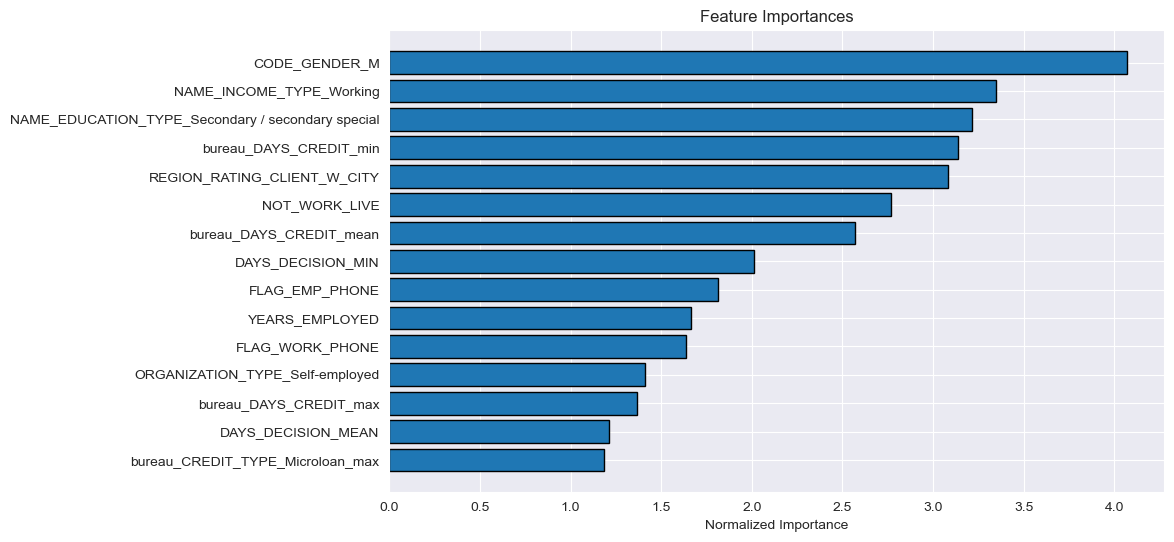

In [7]:
# Logistic regression Model
fi_logit = plot_feature_importances(all_feature_performance['logistic']['feature_importance'])

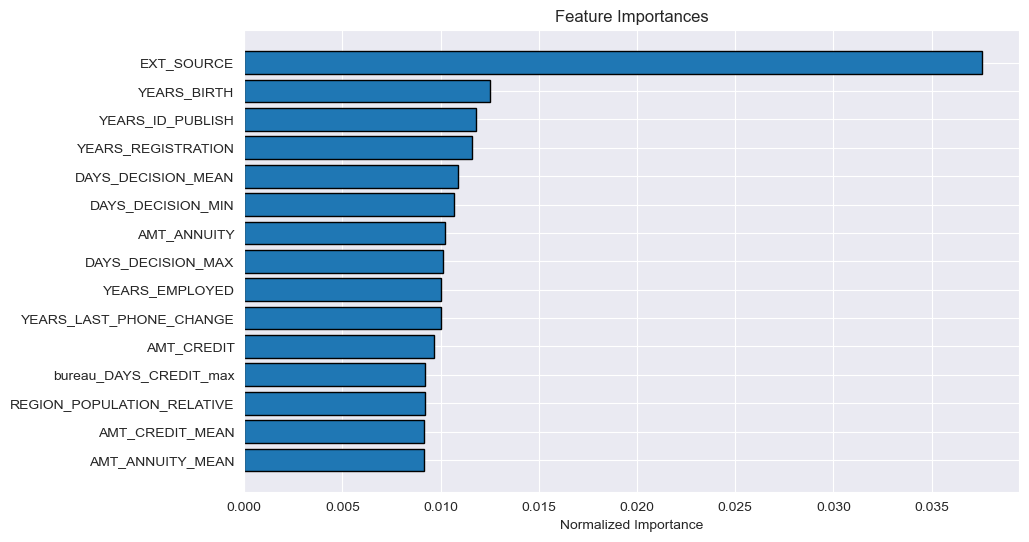

In [8]:
# Random Forest Model
fi_rf = plot_feature_importances(all_feature_performance['RandomForest']['feature_importance'])

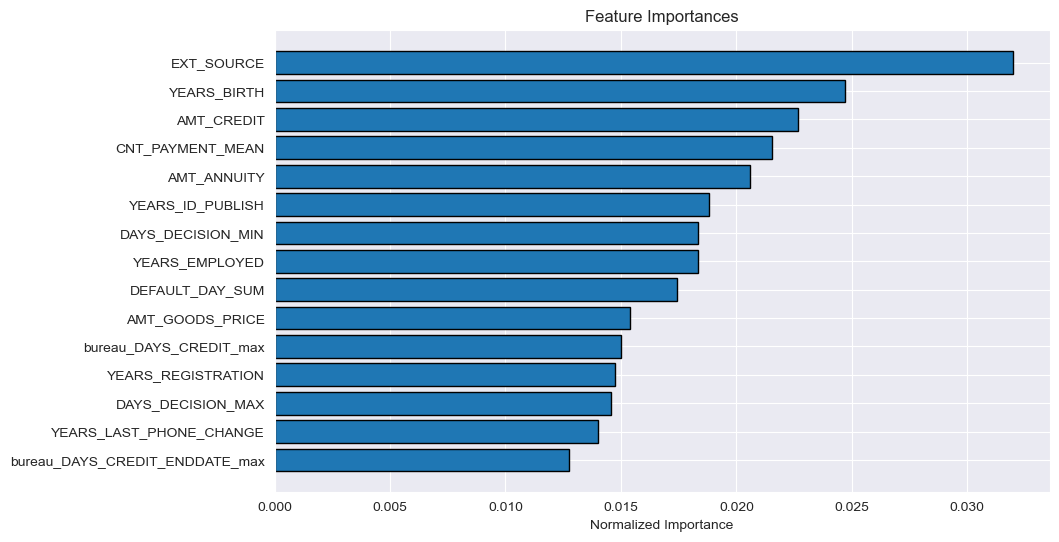

In [9]:
# lgbm
fi_lgbm = plot_feature_importances(all_feature_performance['lgbm']['feature_importance'])

In [10]:
# Intersection
set(fi_rf.head(30)['feature']).intersection(set(fi_logit.head(30)['feature'])).intersection(set(fi_lgbm.head(30)['feature']))

{'CNT_PAYMENT_MEAN',
 'DAYS_DECISION_MEAN',
 'DAYS_DECISION_MIN',
 'YEARS_EMPLOYED',
 'bureau_DAYS_CREDIT_max',
 'bureau_DAYS_CREDIT_mean'}

### Roc plot
***

In this section, we plot the roc and confusion matrix based on different model's result. We do the K-fold validation during each model training section and use the out-of-fold data(valid data) to calculate the roc and confusion matrix. We only use models trained on all feature.

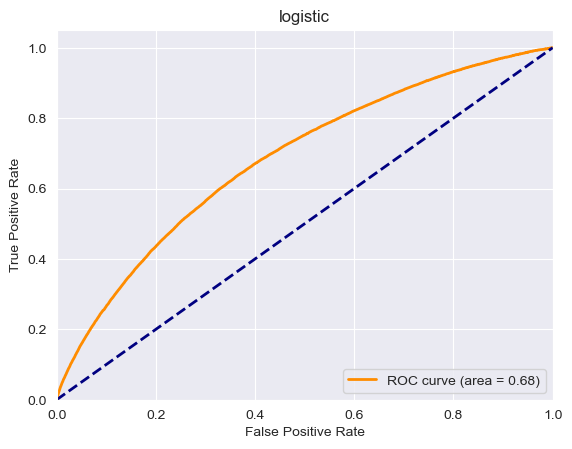

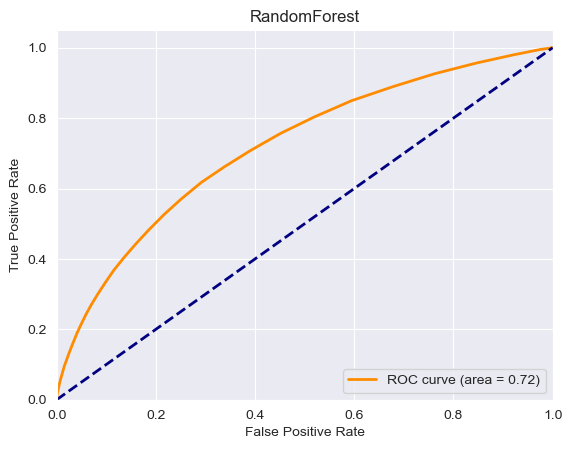

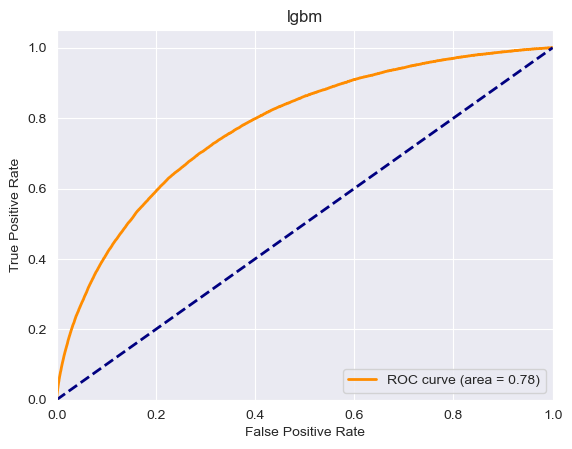

In [13]:
model_l = ['logistic', 'RandomForest', 'lgbm']
for model_n in model_l:
    roc_plot(train['TARGET'], all_feature_performance[model_n]['valid_score'], model_n)

### Confusion Matrix
***

To address this issue, recall rate(sensitivity) is a more important point for us to focus on in model evaluation. Comparing the sensitivity of above three models, it can be found that LGBM performs the best, which is consistent with its performance on kaggle scores.

logistic accuracy:  0.9192711805431351
logistic sensitivity:  0.0


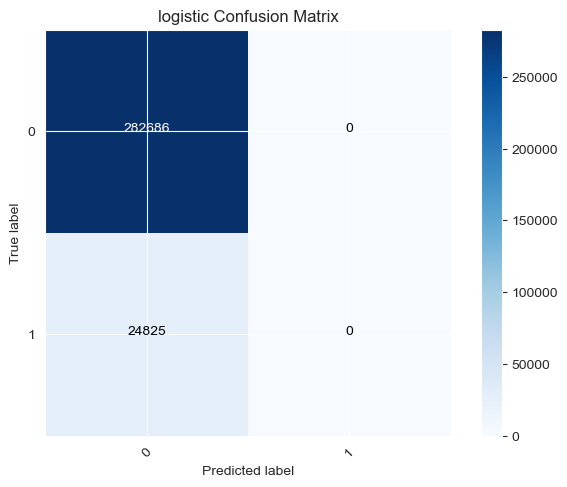

RandomForest accuracy:  0.9193036997050512
RandomForest sensitivity:  0.0004028197381671702


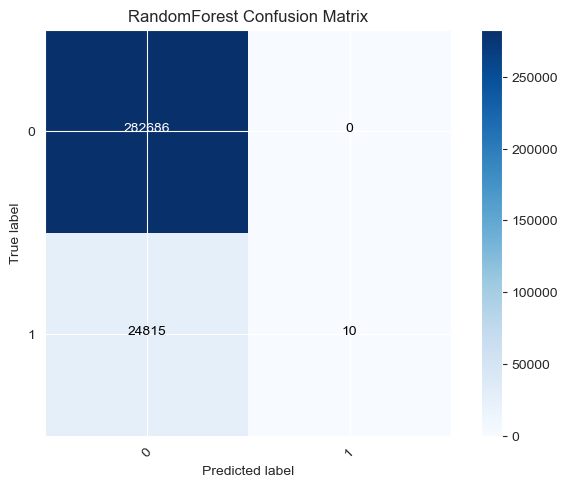

lgbm accuracy:  0.9195898683299134
lgbm sensitivity:  0.009385699899295066


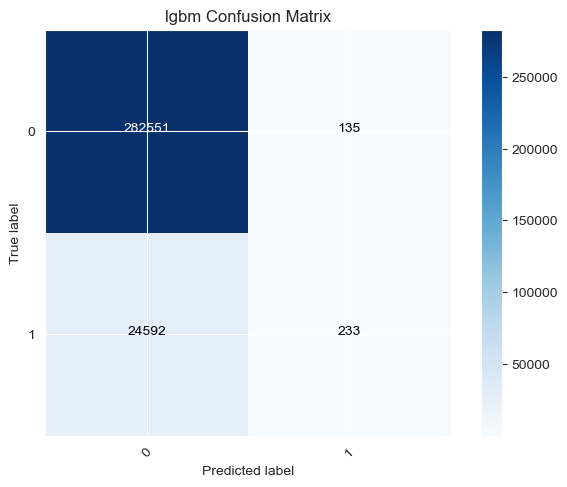

In [14]:
for model_n in model_l:
    plot_confusion_matrix(train['TARGET'], all_feature_performance[model_n]['valid_score'], model_n)

# 5 Appendix
***

This part shows some extra source code for feature generation:
- using application data feature: generate_data()
- using all tabel data feature: generate_data_all()
- using all tabel data and do some feature cleaning: generate_clean_data_all()

In [ ]:
def generate_data():
    application_train = pd.read_csv('application_train.csv')
    application_test = pd.read_csv('application_test.csv')
    # previous_application = pd.read_csv('previous_application.csv')
    HomeCredit_columns_description = pd.read_csv('HomeCredit_columns_description.csv', encoding='ISO-8859-1')

    def remove_missingvalue_columns(train, test, threshold = 0):
        train_miss = pd.DataFrame(train.isnull().sum())
        train_miss['percent'] = 100 * train_miss[0] / len(train)
        test_miss = pd.DataFrame(test.isnull().sum())
        test_miss['percent'] = 100 * test_miss[0] / len(test)

        missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
        missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])

        missing_columns = list(set(missing_train_columns + missing_test_columns))
        train = train.drop(columns = missing_columns)
        test = test.drop(columns = missing_columns)

        print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
        if (missing_train_columns == missing_test_columns):
            print('The columns deleted from the test set and the training set are the same.')
        return train, test

    train, test = remove_missingvalue_columns(application_train, application_test, 60)

    def column_type(df):
        category_list = train.select_dtypes(include=['object']).columns.tolist()
        for column in train.select_dtypes(include=['int64', 'float64']).columns:
            if train[column].nunique() == 2 and set(train[column]) == {0, 1}:
                category_list.append(train[column].name)
        for column in df.columns[df.columns.isin(category_list)]:
            df[column] = df[column].astype('category')
    column_type(test); column_type(train)


    def variable_clean(df, train):
        DOCUMENT_list = [col for col in df.columns if 'FLAG_DOCUMENT_' in col]
        df['FLAG_DOCUMENT'] = df[DOCUMENT_list].sum(axis=1)

        DAYS_list = [col for col in df if 'DAYS_' in col]
        YEARS_list = [item.replace('DAYS_', 'YEARS_') if 'DAYS_' in item else item for item in DAYS_list]
        df[YEARS_list] = -df[DAYS_list]/365

        NOT_WORK_LIVE_list = [col for col in df.columns if ('_NOT_WORK' in col or '_NOT_LIVE' in col)]
        df['NOT_WORK_LIVE'] = df[NOT_WORK_LIVE_list].astype('int64').apply(lambda row: 1 if row.any() else 0, axis=1).astype('category')

        EXT_SOURCE_list = [col for col in df.columns if 'EXT_SOURCE_' in col]
        df['EXT_SOURCE'] = df[EXT_SOURCE_list].mean(axis=1)

        BUILDING_list = HomeCredit_columns_description[HomeCredit_columns_description['Description'].str.contains('building where the client lives')]['Row'].tolist()
        BUILDING_list = list(set(BUILDING_list).intersection(set(df.columns)))

        columns_to_drop = DOCUMENT_list + DAYS_list + ['REGION_RATING_CLIENT'] + NOT_WORK_LIVE_list + EXT_SOURCE_list + BUILDING_list
        df = df.drop(columns=columns_to_drop)


        df.replace('XNA', np.nan, inplace=True)
        for column in df.select_dtypes(include=['int64', 'float64']).columns:
            df[column].fillna(0, inplace=True)

        for column in df.select_dtypes(include=['category']).columns:
            mode_value = train[column].mode()[0]
            df[column].fillna(mode_value, inplace=True)

        dummy_list = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'WEEKDAY_APPR_PROCESS_START',
                      'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_TYPE_SUITE',
                      'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
        df = pd.concat([df, pd.get_dummies(df[dummy_list], prefix=dummy_list, drop_first=True)], axis=1)
        df = df.drop(columns=dummy_list)

        return df

    df_train = variable_clean(train, train)
    df_test = variable_clean(test, train)

    train_labels = df_train['TARGET']
    df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)
    df_train['TARGET'] = train_labels

    return df_train, df_test

# train, test = generate_data()
# train.to_csv('app_train.csv')
# test.to_csv('app_test.csv')

In [ ]:
def generate_data_all():
    application_train = pd.read_csv('application_train.csv')
    application_test = pd.read_csv('application_test.csv')
    previous_application = pd.read_csv('previous_application.csv')
    installments_payments = pd.read_csv('installments_payments.csv')
    HomeCredit_columns_description = pd.read_csv('HomeCredit_columns_description.csv', encoding='ISO-8859-1')
    bureau_balance = pd.read_csv('bureau_balance.csv')
    bureau = pd.read_csv('bureau.csv')

    def remove_missingvalue_columns(train, test, threshold = 0):
        train_miss = pd.DataFrame(train.isnull().sum())
        train_miss['percent'] = 100 * train_miss[0] / len(train)
        test_miss = pd.DataFrame(test.isnull().sum())
        test_miss['percent'] = 100 * test_miss[0] / len(test)

        missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
        missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])

        missing_columns = list(set(missing_train_columns + missing_test_columns))
        train = train.drop(columns = missing_columns)
        test = test.drop(columns = missing_columns)

        print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
        if (missing_train_columns == missing_test_columns):
            print('The columns deleted from the test set and the training set are the same.')
        return train, test

    train, test = remove_missingvalue_columns(application_train, application_test, 60)

    def column_type(df):
        category_list = train.select_dtypes(include=['object']).columns.tolist()
        for column in train.select_dtypes(include=['int64', 'float64']).columns:
            if train[column].nunique() == 2 and set(train[column]) == {0, 1}:
                category_list.append(train[column].name)
        for column in df.columns[df.columns.isin(category_list)]:
            df[column] = df[column].astype('category')

    column_type(test); column_type(train)

    def variable_clean(df, train):
        DOCUMENT_list = [col for col in df.columns if 'FLAG_DOCUMENT_' in col]
        df['FLAG_DOCUMENT'] = df[DOCUMENT_list].astype(int).sum(axis=1)

        DAYS_list = [col for col in df if 'DAYS_' in col]
        YEARS_list = [item.replace('DAYS_', 'YEARS_') if 'DAYS_' in item else item for item in DAYS_list]
        df[YEARS_list] = -df[DAYS_list]/365

        NOT_WORK_LIVE_list = [col for col in df.columns if ('_NOT_WORK' in col or '_NOT_LIVE' in col)]
        df['NOT_WORK_LIVE'] = df[NOT_WORK_LIVE_list].astype('int64').apply(lambda row: 1 if row.any() else 0, axis=1).astype('category')

        EXT_SOURCE_list = [col for col in df.columns if 'EXT_SOURCE_' in col]
        df['EXT_SOURCE'] = df[EXT_SOURCE_list].mean(axis=1)

        BUILDING_list = HomeCredit_columns_description[HomeCredit_columns_description['Description'].str.contains('building where the client lives')]['Row'].tolist()
        BUILDING_list = list(set(BUILDING_list).intersection(set(df.columns)))

        columns_to_drop = DOCUMENT_list + DAYS_list + ['REGION_RATING_CLIENT'] + NOT_WORK_LIVE_list + EXT_SOURCE_list + BUILDING_list
        df = df.drop(columns=columns_to_drop)

        df.replace('XNA', np.nan, inplace=True)
        for column in df.select_dtypes(include=['int64', 'float64']).columns:
            df[column].fillna(0, inplace=True)

        df_copy = df.copy()
        for column in df_copy.select_dtypes(include=['category']).columns:
            mode_value = train[column].mode()[0]
            df_copy[column].fillna(mode_value, inplace=True)

        dummy_list = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'WEEKDAY_APPR_PROCESS_START',
                      'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_TYPE_SUITE',
                      'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
        df_copy = pd.concat([df_copy, pd.get_dummies(df_copy[dummy_list], prefix=dummy_list, drop_first=True)], axis=1)
        df_copy = df_copy.drop(columns=dummy_list)

        return df_copy

    df_train = variable_clean(train, train)
    df_test = variable_clean(test, train)

    train_labels = df_train['TARGET']
    df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)
    df_train['TARGET'] = train_labels
    print('------------------application data done!')
    # ==================== previous_application table==========================
    # -------------------------------------------------------------------------
    installments_payments['DEFAULT_DAY']=installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
    tem =installments_payments[installments_payments['DEFAULT_DAY'] > 0]
    tem = tem.loc[: ,['SK_ID_CURR','DEFAULT_DAY']]
    default_days_agg = tem.groupby('SK_ID_CURR', as_index = False).agg({ 'DEFAULT_DAY' : ['sum', 'count']})
    default_days_agg.columns = ['SK_ID_CURR', 'DEFAULT_DAY_SUM', 'DEFAULT_DAY_COUNT']

    installments_payments['DEFAULT_AMT']=installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']
    tem =installments_payments[installments_payments['DEFAULT_AMT'] > 0]
    tem = tem.loc[: ,['SK_ID_CURR','DEFAULT_AMT']]
    default_AMT_agg = tem.groupby('SK_ID_CURR', as_index = False).agg({ 'DEFAULT_AMT' : ['sum', 'count']})
    default_AMT_agg.columns = ['SK_ID_CURR', 'DEFAULT_AMT_SUM', 'DEFAULT_AMT_COUNT']

    df_train = df_train.merge(default_days_agg, how = 'left', on = 'SK_ID_CURR')
    df_test = df_test.merge(default_days_agg, how = 'left', on = 'SK_ID_CURR')

    df_train = df_train.merge(default_AMT_agg, how = 'left', on = 'SK_ID_CURR')
    df_test = df_test.merge(default_AMT_agg, how = 'left', on = 'SK_ID_CURR')

    def one_hot_encoder(df, nan_category = True):
        original_cols = list(df.columns)
        categorial_cols = [col for col in df.columns if df[col].dtypes == 'object']
        df = pd.get_dummies(df, columns = categorial_cols, dummy_na = nan_category, drop_first=True)
        new_columns = [i for i in df.columns if i not in original_cols]
        return df, new_columns

    previous_app = previous_application
    previous_app_numeric = previous_app.select_dtypes(include=['number'])
    missings = previous_app_numeric.loc[:,previous_app_numeric.isna().mean() >= 0.6]
    highly_missing_features = missings.columns
    previous_app.drop(highly_missing_features, axis=1, inplace=True)

    previous_app_obj = previous_app.dtypes[previous_app.dtypes == 'object'].index
    previous_app[previous_app_obj].apply(pd.Series.nunique, axis = 0)
    previous_app, previous_app_cat = one_hot_encoder(previous_app)

    NA_list = [col for col in previous_app.columns if 'XNA' in col or 'nan' in col or 'XAP' in col]
    previous_app_cat = list(set(NA_list).symmetric_difference(set(previous_app_cat)))
    previous_app = previous_app.drop(columns=NA_list)
    cat_agg = { }
    for i in previous_app_cat:
        cat_agg[i] = 'sum'

    num_agg = {
        'AMT_ANNUITY': ['min','max','mean'],
        'AMT_APPLICATION':['min','max','mean'],
        'AMT_CREDIT':['min','max','mean'],
        'AMT_DOWN_PAYMENT':['min','max','mean'],
        'AMT_GOODS_PRICE':['min','max','mean'],
        'HOUR_APPR_PROCESS_START':['min','max','mean'],
        'RATE_DOWN_PAYMENT':['min','max','mean'],
        'DAYS_DECISION':['min','max','mean'],
        'CNT_PAYMENT':['sum','mean']
    }
    previous_application_agg = previous_app.groupby('SK_ID_CURR', as_index = False).agg({**cat_agg, **num_agg})
    previous_application_agg.columns = ['_'.join(col) for col in previous_application_agg.columns.values]
    previous_application_agg.columns = [col.upper() for col in previous_application_agg.columns.values]
    previous_application_agg.rename(columns={'SK_ID_CURR_': 'SK_ID_CURR'}, inplace=True)

    df_train = df_train.merge(previous_application_agg, how = 'left', on = 'SK_ID_CURR')
    df_test = df_test.merge(previous_application_agg, how = 'left', on = 'SK_ID_CURR')
    df_train.fillna(0, inplace=True); df_test.fillna(0, inplace=True)
    print('-----------------previous application done!')
    # =========================== bureau table ==============================
    # -----------------------------------------------------------------------

    b_obj = bureau.dtypes[bureau.dtypes == 'object'].index
    bb_obj = bureau_balance.dtypes[bureau_balance.dtypes == 'object'].index
    bureau[b_obj].apply(pd.Series.nunique, axis = 0)
    bureau_balance[bb_obj].apply(pd.Series.nunique, axis = 0)

    b, b_cat = one_hot_encoder(bureau)
    bb, bb_cat = one_hot_encoder(bureau_balance)

    NA_list = [col for col in b.columns if 'nan' in col]
    b_cat = list(set(NA_list).symmetric_difference(set(b_cat)))
    b = b.drop(columns=NA_list)

    NA_list = [col for col in bb.columns if 'nan' in col]
    bb_cat = list(set(NA_list).symmetric_difference(set(bb_cat)))
    bb = bb.drop(columns=NA_list)

    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size'] }

    for i in bb_cat:
        bb_aggregations[i] = ['mean', 'sum'] #算出占比和总次数

    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    tem = []
    for i in bb_agg.columns.tolist():
        tem.append(i[0] + '_' + i[1])

    b = b.join(bb_agg, how='left', on='SK_ID_BUREAU')
    b.drop(['SK_ID_BUREAU'], axis= 1, inplace= True)

    tem = b.columns.tolist()
    num_agg = { }
    for i in tem:
        if i != 'SK_ID_CURR':
            num_agg[i] = ['min', 'max', 'mean', 'var', 'sum']

    bureau_agg = b.groupby('SK_ID_CURR', as_index = False).agg(num_agg)

    tem = [ ]
    tem.append('SK_ID_CURR')
    for i in bureau_agg.columns.tolist():
        if i[0] != 'SK_ID_CURR':
            tem.append('bureau' + '_' + str(i[0]) + '_' + str(i[1]))

    bureau_agg.columns = pd.Index(tem)
    print('--------------------- bureau data done!')

    df_train = df_train.merge(bureau_agg, how = 'left', on = 'SK_ID_CURR')
    df_test = df_test.merge(bureau_agg, how = 'left', on = 'SK_ID_CURR')
    df_train.fillna(0, inplace=True); df_test.fillna(0, inplace=True)

    return df_train, df_test

# train, test = generate_data_all()
# train.to_csv('all_train.csv')
# test.to_csv('all_test.csv')

In [ ]:
def generate_clean_data_all():
    application_train = pd.read_csv('application_train.csv')
    application_test = pd.read_csv('application_test.csv')
    previous_application = pd.read_csv('previous_application.csv')
    installments_payments = pd.read_csv('installments_payments.csv')
    HomeCredit_columns_description = pd.read_csv('HomeCredit_columns_description.csv', encoding='ISO-8859-1')
    bureau_balance = pd.read_csv('bureau_balance.csv')
    bureau = pd.read_csv('bureau.csv')

    def remove_missingvalue_columns(train, test, threshold = 0):
        train_miss = pd.DataFrame(train.isnull().sum())
        train_miss['percent'] = 100 * train_miss[0] / len(train)
        test_miss = pd.DataFrame(test.isnull().sum())
        test_miss['percent'] = 100 * test_miss[0] / len(test)

        missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
        missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])

        missing_columns = list(set(missing_train_columns + missing_test_columns))
        train = train.drop(columns = missing_columns)
        test = test.drop(columns = missing_columns)

        print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
        if (missing_train_columns == missing_test_columns):
            print('The columns deleted from the test set and the training set are the same.')
        return train, test

    train, test = remove_missingvalue_columns(application_train, application_test, 60)

    def column_type(df):
        category_list = train.select_dtypes(include=['object']).columns.tolist()
        for column in train.select_dtypes(include=['int64', 'float64']).columns:
            if train[column].nunique() == 2 and set(train[column]) == {0, 1}:
                category_list.append(train[column].name)
        for column in df.columns[df.columns.isin(category_list)]:
            df[column] = df[column].astype('category')

    column_type(test); column_type(train)

    def variable_clean(df, train):
        DOCUMENT_list = [col for col in df.columns if 'FLAG_DOCUMENT_' in col]
        df['FLAG_DOCUMENT'] = df[DOCUMENT_list].astype(int).sum(axis=1)

        DAYS_list = [col for col in df if 'DAYS_' in col]
        YEARS_list = [item.replace('DAYS_', 'YEARS_') if 'DAYS_' in item else item for item in DAYS_list]
        df[YEARS_list] = -df[DAYS_list]/365

        NOT_WORK_LIVE_list = [col for col in df.columns if ('_NOT_WORK' in col or '_NOT_LIVE' in col)]
        df['NOT_WORK_LIVE'] = df[NOT_WORK_LIVE_list].astype('int64').apply(lambda row: 1 if row.any() else 0, axis=1).astype('category')

        EXT_SOURCE_list = [col for col in df.columns if 'EXT_SOURCE_' in col]
        df['EXT_SOURCE'] = df[EXT_SOURCE_list].mean(axis=1)

        BUILDING_list = HomeCredit_columns_description[HomeCredit_columns_description['Description'].str.contains('building where the client lives')]['Row'].tolist()
        BUILDING_list = list(set(BUILDING_list).intersection(set(df.columns)))

        columns_to_drop = DOCUMENT_list + DAYS_list + ['REGION_RATING_CLIENT'] + NOT_WORK_LIVE_list + EXT_SOURCE_list + BUILDING_list
        df = df.drop(columns=columns_to_drop)

        df.replace('XNA', np.nan, inplace=True)
        for column in df.select_dtypes(include=['int64', 'float64']).columns:
            df[column].fillna(0, inplace=True)

        df_copy = df.copy()
        for column in df_copy.select_dtypes(include=['category']).columns:
            mode_value = train[column].mode()[0]
            df_copy[column].fillna(mode_value, inplace=True)

        dummy_list = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'WEEKDAY_APPR_PROCESS_START',
                      'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_TYPE_SUITE',
                      'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
        df_copy = pd.concat([df_copy, pd.get_dummies(df_copy[dummy_list], prefix=dummy_list, drop_first=True)], axis=1)
        df_copy = df_copy.drop(columns=dummy_list)

        return df_copy

    df_train = variable_clean(train, train)
    df_test = variable_clean(test, train)

    train_labels = df_train['TARGET']
    df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)
    df_train['TARGET'] = train_labels
    print('------------------application data done!')

    # ================ user id identify - previous default ====================
    # -------------------------------------------------------------------------
    prev_app = previous_application[['SK_ID_CURR', 'DAYS_DECISION']].drop_duplicates()
    app_train = application_train[['SK_ID_CURR', 'DAYS_BIRTH', 'CODE_GENDER']]
    app_test = application_test[['SK_ID_CURR', 'DAYS_BIRTH', 'CODE_GENDER']]
    prev_app = pd.merge(prev_app, pd.concat([app_train, app_test], axis=0), how='left', on='SK_ID_CURR')
    prev_app['DAYS_BIRTH_PREV'] = prev_app['DAYS_BIRTH'] - prev_app['DAYS_DECISION']
    prev_app = prev_app.sort_values(by=['SK_ID_CURR', 'DAYS_DECISION']).reset_index()
    prev_app_grouped = prev_app.groupby('SK_ID_CURR')['DAYS_DECISION'].diff().reset_index(name='DAYS_DECISION_DIFF')
    prev_app = prev_app.merge(prev_app_grouped, left_index=True, right_index=True, how='left')
    prev_app['DAYS_DECISION_DIFF'] = -prev_app['DAYS_DECISION_DIFF']
    prev_app = prev_app[['SK_ID_CURR', 'CODE_GENDER', 'DAYS_DECISION', 'DAYS_BIRTH', 'DAYS_DECISION_DIFF', 'DAYS_BIRTH_PREV']]

    prev_app_1 = prev_app[['SK_ID_CURR', 'CODE_GENDER', 'DAYS_DECISION', 'DAYS_BIRTH']]
    prev_app_2 = prev_app[['SK_ID_CURR', 'CODE_GENDER', 'DAYS_DECISION_DIFF', 'DAYS_BIRTH_PREV']]
    prev_app_2.columns = prev_app_1.columns
    merged = prev_app_1.merge(prev_app_2, on=['CODE_GENDER', 'DAYS_DECISION', 'DAYS_BIRTH'], how='inner')

    pairs = merged[['SK_ID_CURR_x', 'SK_ID_CURR_y']]
    pairs = pairs.copy()
    pairs['x_target'] = pairs['SK_ID_CURR_x'].map(train.set_index('SK_ID_CURR')['TARGET'])
    pairs['y_target'] = pairs['SK_ID_CURR_y'].map(train.set_index('SK_ID_CURR')['TARGET'])

    df_birth = pd.concat([app_train, app_test], axis=0)
    pairs['x_birth'] = pairs['SK_ID_CURR_x'].map(df_birth.set_index('SK_ID_CURR')['DAYS_BIRTH'])
    pairs['y_birth'] = pairs['SK_ID_CURR_y'].map(df_birth.set_index('SK_ID_CURR')['DAYS_BIRTH'])

    combined_series = pd.concat([pairs['SK_ID_CURR_x'], pairs['SK_ID_CURR_y']], ignore_index=True)
    combined_unique = combined_series.drop_duplicates().reset_index()

    birth_data = df_birth[df_birth['SK_ID_CURR'].isin(combined_unique[0].tolist())][['SK_ID_CURR', 'DAYS_BIRTH']]
    result_df = pd.DataFrame({'SK_ID_CURR': combined_unique[0].tolist(), 'prev_default': np.nan})

    for i, row in birth_data.iterrows():
        curr_SK_ID_CURR = row['SK_ID_CURR']
        birth = row['DAYS_BIRTH']

        df = pairs[(pairs['SK_ID_CURR_x'] == curr_SK_ID_CURR) | (pairs['SK_ID_CURR_y'] == curr_SK_ID_CURR)]
        df2 = df[(df['x_birth'] < birth) | (df['y_birth'] < birth)]

        x_condition = df2['x_birth'] == birth
        y_condition = df2['y_birth'] == birth

        df2 = df2.copy()
        df2['prev_default'] = np.where(x_condition, df2['y_target'], np.where(y_condition, df2['x_target'], None))
        prev_default = df2['prev_default'].sum()

        result_df.loc[result_df['SK_ID_CURR'] == curr_SK_ID_CURR, 'prev_default'] = prev_default

    df_train = df_train.merge(result_df, how = 'left', on = 'SK_ID_CURR')
    df_test = df_test.merge(result_df, how = 'left', on = 'SK_ID_CURR')
    df_train.fillna(0, inplace=True); df_test.fillna(0, inplace=True)
    print('------------------previous default done!')

    # ==================== previous_application table==========================
    # -------------------------------------------------------------------------
    installments_payments['DEFAULT_DAY']=installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
    tem =installments_payments[installments_payments['DEFAULT_DAY'] > 0]
    tem = tem.loc[: ,['SK_ID_CURR','DEFAULT_DAY']]
    default_days_agg = tem.groupby('SK_ID_CURR', as_index = False).agg({ 'DEFAULT_DAY' : ['sum', 'count']})
    default_days_agg.columns = ['SK_ID_CURR', 'DEFAULT_DAY_SUM', 'DEFAULT_DAY_COUNT']

    installments_payments['DEFAULT_AMT']=installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']
    tem =installments_payments[installments_payments['DEFAULT_AMT'] > 0]
    tem = tem.loc[: ,['SK_ID_CURR','DEFAULT_AMT']]
    default_AMT_agg = tem.groupby('SK_ID_CURR', as_index = False).agg({ 'DEFAULT_AMT' : ['sum', 'count']})
    default_AMT_agg.columns = ['SK_ID_CURR', 'DEFAULT_AMT_SUM', 'DEFAULT_AMT_COUNT']

    df_train = df_train.merge(default_days_agg, how = 'left', on = 'SK_ID_CURR')
    df_test = df_test.merge(default_days_agg, how = 'left', on = 'SK_ID_CURR')

    df_train = df_train.merge(default_AMT_agg, how = 'left', on = 'SK_ID_CURR')
    df_test = df_test.merge(default_AMT_agg, how = 'left', on = 'SK_ID_CURR')

    def one_hot_encoder(df, nan_category = True):
        original_cols = list(df.columns)
        categorial_cols = [col for col in df.columns if df[col].dtypes == 'object']
        df = pd.get_dummies(df, columns = categorial_cols, dummy_na = nan_category, drop_first=True)
        new_columns = [i for i in df.columns if i not in original_cols]
        return df, new_columns

    previous_app = previous_application
    previous_app_numeric = previous_app.select_dtypes(include=['number'])
    missings = previous_app_numeric.loc[:,previous_app_numeric.isna().mean() >= 0.6]
    highly_missing_features = missings.columns
    previous_app.drop(highly_missing_features, axis=1, inplace=True)

    previous_app_obj = previous_app.dtypes[previous_app.dtypes == 'object'].index
    previous_app[previous_app_obj].apply(pd.Series.nunique, axis = 0)
    previous_app, previous_app_cat = one_hot_encoder(previous_app)

    NA_list = [col for col in previous_app.columns if 'XNA' in col or 'nan' in col or 'XAP' in col]
    previous_app_cat = list(set(NA_list).symmetric_difference(set(previous_app_cat)))
    previous_app = previous_app.drop(columns=NA_list)
    cat_agg = { }
    for i in previous_app_cat:
        cat_agg[i] = 'sum'

    num_agg = {
        'AMT_ANNUITY': ['min','max','mean'],
        'AMT_APPLICATION':['min','max','mean'],
        'AMT_CREDIT':['min','max','mean'],
        'AMT_DOWN_PAYMENT':['min','max','mean'],
        'AMT_GOODS_PRICE':['min','max','mean'],
        'HOUR_APPR_PROCESS_START':['min','max','mean'],
        'RATE_DOWN_PAYMENT':['min','max','mean'],
        'DAYS_DECISION':['min','max','mean'],
        'CNT_PAYMENT':['sum','mean']
    }
    previous_application_agg = previous_app.groupby('SK_ID_CURR', as_index = False).agg({**cat_agg, **num_agg})
    previous_application_agg.columns = ['_'.join(col) for col in previous_application_agg.columns.values]
    previous_application_agg.columns = [col.upper() for col in previous_application_agg.columns.values]
    previous_application_agg.rename(columns={'SK_ID_CURR_': 'SK_ID_CURR'}, inplace=True)

    df_train = df_train.merge(previous_application_agg, how = 'left', on = 'SK_ID_CURR')
    df_test = df_test.merge(previous_application_agg, how = 'left', on = 'SK_ID_CURR')
    df_train.fillna(0, inplace=True); df_test.fillna(0, inplace=True)
    print('-----------------previous application done!')

    # =========================== bureau table ==============================
    # -----------------------------------------------------------------------

    b_obj = bureau.dtypes[bureau.dtypes == 'object'].index
    bb_obj = bureau_balance.dtypes[bureau_balance.dtypes == 'object'].index
    bureau[b_obj].apply(pd.Series.nunique, axis = 0)
    bureau_balance[bb_obj].apply(pd.Series.nunique, axis = 0)

    b, b_cat = one_hot_encoder(bureau)
    bb, bb_cat = one_hot_encoder(bureau_balance)
    NA_list = [col for col in b.columns if 'nan' in col]
    b_cat = list(set(NA_list).symmetric_difference(set(b_cat)))
    b = b.drop(columns=NA_list)
    NA_list = [col for col in bb.columns if 'nan' in col]
    bb_cat = list(set(NA_list).symmetric_difference(set(bb_cat)))
    bb = bb.drop(columns=NA_list)

    b = b.merge(bb, how= 'left', on='SK_ID_BUREAU')
    b.drop(['SK_ID_BUREAU'], axis= 1, inplace= True)
    tem = b.columns.tolist()
    num_agg = { }
    for i in tem:
        if i != 'SK_ID_CURR':
            num_agg[i] = ['min', 'max', 'mean', 'var', 'sum']

    bureau_agg = b.groupby('SK_ID_CURR', as_index = False).agg(num_agg)

    tem = [ ]
    tem.append('SK_ID_CURR')
    for i in bureau_agg.columns.tolist():
        if i[0] != 'SK_ID_CURR':
            tem.append('bureau' + '_' + str(i[0]) + '_' + str(i[1]))

    bureau_agg.columns = pd.Index(tem)
    df_train = df_train.merge(bureau_agg, how = 'left', on = 'SK_ID_CURR')
    df_test = df_test.merge(bureau_agg, how = 'left', on = 'SK_ID_CURR')
    df_train.fillna(0, inplace=True); df_test.fillna(0, inplace=True)
    print('--------------------- bureau data done!')

    return df_train, df_test

# train_clean, test_clean = generate_clean_data_all()
# train_clean.to_csv('train_clean.csv')
# test_clean.to_csv('test_clean.csv')